# Motion artefact correction and physiological noise removal

This work is based on the excellent tutorials created by the MNE and MNE-NIRS developers:

- **MNE**: [Tutorials](https://mne.tools/stable/auto_tutorials/index.html)
- **MNE-NIRS**: [Examples](https://mne.tools/mne-nirs/stable/auto_examples/index.html)


## Table of Contents
* [Pre-processing](#chapter_1)
    * [Load python modules](#section_1_1)
    * [Import data](#section_1_2)
        * [Import snirf data](#sub_section_1_2_1)
        * [Add info to raw intensity data](#sub_section_1_2_2)
    * [Signal quality metrics and channel rejection](#section_1_3)
        * [Visual inspection](#sub_section_1_3_1)
        * [Scalp-coupling index](#sub_section_1_3_2)
        * [Peak spectral power](#sub_section_1_3_3)
    * [Motion artefact correction](#section_1_4)
    * [Short channel regression](#section_1_5)
        * [Method of Saager and Berger](#sub_section_1_5_1)
    * [Global component derived from the mean or median](#section_1_6)
        * [Method of Saager and Berger](#sub_section_1_6_1)
    * [Signal processing methods](#section_1_7)
        * [Bandpass filtering](#sub_section_1_7_1)
        * [Fitting Oscillations & One Over F (FOOOF)](#sub_section_1_7_2)

## Pre-processing <a class="anchor" id="chapter_1"></a>

---
### Load python modules <a class="anchor" id="section_1_1"></a>

In [3]:
# Import the needed modules 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mne
import mne_nirs
import pywt
import scipy
import dabest
import pathlib
from itertools import compress
from mne.preprocessing.nirs import scalp_coupling_index, optical_density, temporal_derivative_distribution_repair, beer_lambert_law, _validate_nirs_info, source_detector_distances
from mne_nirs.preprocessing import peak_power, scalp_coupling_index_windowed, quantify_mayer_fooof
from mne_nirs.visualisation import plot_timechannel_quality_metric
from mne_nirs.channels import get_short_channels, get_long_channels, picks_pair_to_idx
from mne_nirs.signal_enhancement import short_channel_regression
from mne_nirs.experimental_design import make_first_level_design_matrix
from mne.preprocessing import ICA, corrmap
from mne_bids import BIDSPath, read_raw_bids
from scipy.stats import norm, ttest_1samp, kurtosis, pearsonr
from scipy.signal import firwin, freqz, filtfilt
from scipy.interpolate import CubicSpline
from fooof import FOOOF
from csaps import csaps
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import StandardScaler

C:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,
C:\Users\fabia\AppData\Local\Temp\ipykernel_12440\1896447934.py:24: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof import FOOOF


In [4]:
# Write own fucntions
def reorder(raw_initial):
    """
    Input: raw object
    Function: reorders the channels to match the MNE standard
    """
    raw = raw_initial.copy()
    channel_names = raw.ch_names
    channel_names_ordered = []
    for i in range(0, int(len(channel_names)/2)):
        channel_names_ordered.append(channel_names[i])
        channel_names_ordered.append(channel_names[(i + int(len(channel_names)/2))])
    raw_ordered = raw.reorder_channels(channel_names_ordered)
    return raw_ordered

def add_info(raw_intensity, first_name, last_name, age, sex, EHI, annotations, duration_annotation, duration_rest, N_control):
    """
    Input: raw object, first name, last name, age, sex, EHI, annotations, duration of annotation, duration of baseline period, # of control trials
    Function: Returns raw object with added subject info and random allocated control trials within the baseline period
    """
    raw = raw_intensity.copy()
    
    # Add subject info
    raw.info["subject_info"] = {'first_name' : first_name, 'last_name' : last_name, 'age' : age, 'sex' : sex, 'EHI' : EHI}
    
    # attribute meaningful names to trigger codes. Include information about the duration of each stimulus (10 seconds). 
    raw.annotations.set_durations(duration_annotation)
    raw.annotations.rename(annotations)
    
    events, event_dict = mne.events_from_annotations(raw)
    
    # Define begin and end of rest period
    begin_rest = np.ceil(events[np.where(events[:,2] == event_dict['Baseline'])[0][0],0]/raw.info['sfreq'])
    end_rest = begin_rest + duration_rest - duration_annotation 
    
    # Remove start indicator of rest period
    raw.annotations.delete(np.nonzero(raw.annotations.description == "Baseline"))
    
    # Define indices of random selected control trials
    indices = np.random.choice(np.arange(begin_rest, end_rest), N_control, replace = False).astype(int)
    raw.annotations.append(indices, [duration_annotation]*N_control, ["Baseline"]*N_control)
    
    return raw

def add_info2(raw_intensity, first_name, last_name, age, sex, EHI):
    """
    Input: raw object, first name, last name, age, sex, EHI
    Function: Returns raw object with added subject info
    """
    raw = raw_intensity.copy()
    
    # Add subject info
    raw.info["subject_info"] = {'first_name' : first_name, 'last_name' : last_name, 'age' : age, 'sex' : sex, 'EHI' : EHI}
    
    return raw
    
def crop(raw_input, t_before = 10, t_after = 60):
    """
    Input: raw object, time interval length before first event and time interval length after last event that should be included in the recording
    Function: crops raw object to a recording starting 't_before' s (default 10 s) before the first annotated event and ending 't_after' s (default 60 s) after the last event 
    """
    raw = raw_input.copy()
    end_rec = raw.get_data().shape[1]/raw.info['sfreq']
    t_start = events[0,0]/raw.info['sfreq'] - t_before
    t_end = events[-1,0]/raw.info['sfreq'] + t_after
    if t_start < 10:
        t_start = 0
    if t_end > end_rec:
        t_end = end_rec
    raw.crop(t_start, t_end)
    return raw

def get_indices(array, target_array):
    """
    Input: complete array of channel names, array of channels names to be removed
    Function: gives back indices of desired channels
    """
    lst = list(array)
    indices = list(np.arange(0, len(array)))
    for target in target_array:
        if target in lst:
            indices.remove(lst.index(target))
    return indices

def ch_names_L_R(raw):
    """
    Input: raw object
    Function: Separate list of channel names in 2 lists for the left and right hemisphere respectively
    """
    left, right = [], []
    for ch in raw.ch_names:
        if (int(ch[1]) % 2) == 0:
            right.append(ch)
        else:
            left.append(ch)
    return left, right

def scale_up_spectra(spectra, freqs):
    """
    Input: spectra, freqs
    Function: FOOOF requires the frequency values to be higher than the fNIRS data permits, 
    so we scale the values up by 10 here, and then will scale
    the frequency values down by 10 later.
    """
    freqs = freqs * 10
    return spectra, freqs

def get_IMU_data(filename, plot = False):
    """
    Extract IMU data from text file.
    Input: filename with .txt, plot (bool)
    Output: Three dataframes containing the complete IMU data, the accelerometer data and the gyroscope data respectively
    """
    
    # Read .txt file and convert to dataframe
    df = pd.read_csv(filename, sep=';', header=None, names=["time", "battery", "channels", "gyroX", "gyroY", "gyroZ", "accX", "accY", "accZ", "marker", "_"])

    # Select IMU data
    data = df.drop(0)
    markers = data["marker"].astype(float)
    IMU_data = data.drop(columns =['time', 'battery', 'channels', 'marker', '_']).astype(float)

    gyro_data = IMU_data.drop(columns = ['accX', 'accY', 'accZ'])
    acc_data = IMU_data.drop(columns = ["gyroX", "gyroY", "gyroZ"])
    
    if plot: 
        %matplotlib inline
        gyro_data.plot(title='Gyroscope data', grid = True, xlabel = 'samples', ylabel = 'dps')
        acc_data.plot(title='Accelerometer data', grid = True, xlabel = 'samples', ylabel = 'm/s^2')

    return IMU_data, acc_data, gyro_data

def compare_original_filtered(raw_filtered, raw_unfiltered, export = False, filename = None):
    data_new = raw_filtered.get_data()
    data = raw_unfiltered.get_data()
    picks = np.sort(_validate_nirs_info(raw_filtered.info))
    datatype = raw_filtered.ch_names[0][-3:]
    for pick in picks:
        if plot:
            if datatype == 'hbo':
                type = ' hbo' if pick%2 == 0 else ' hbr'
                ylabel = 'HbO/HbR (M)'
            else:
                type = ' wavelength 760' if pick%2 == 0 else ' wavelength 850'
                ylabel = 'OD (V)'
            %matplotlib inline
            time = np.arange(data.shape[1])/raw_filtered.info['sfreq']
            fig = plt.figure(figsize = (12,5))
            plt.plot(time, data[pick], label = 'original')
            plt.plot(time, data_new[pick], label = 'filtered')
            plt.xlabel('time (s)')
            plt.ylabel(ylabel)
            plt.title('Channel: ' + str(pick//2+1) + type)
            plt.legend()
            if export:
                if filename == None:
                    raise ValueError('Filename must be given to export figures')
                fig.savefig(filename + '_channel_' + str(pick//2+1) + type + '.png')
            plt.show()

In [5]:
# Set plot characteristics
%matplotlib inline
sns.set_theme() # nicer plots
# Load external plots?
plot = False
# Export figures?
export = False

### Import data <a class="anchor" id="section_1_2"></a>

#### Import snirf data <a class="anchor" id="sub_section_1_2_1"></a>

In [6]:
raws2 = []
data_dir = pathlib.Path("C:/Users/fabia/fNIRS data analysis/FTT analysis/FTT2/FTT2 data_BIDS")
bids_root = data_dir.with_name(data_dir.name)
for sub in range(1, 5):  # Loop from first to fourth subject
    # Create path to file based on experiment info
    bids_path = BIDSPath(subject="%02d" % sub, task="grasping", datatype="nirs",
                         root=bids_root, suffix="nirs",
                         extension=".snirf")
    raws2.append(read_raw_bids(bids_path=bids_path, verbose=False))
raws2

C:\Users\fabia\AppData\Local\Temp\ipykernel_12440\937361362.py:9: RuntimeWarning: Unable to map "sex" value "None" to MNE. Not setting subject sex.
  raws2.append(read_raw_bids(bids_path=bids_path, verbose=False))
C:\Users\fabia\AppData\Local\Temp\ipykernel_12440\937361362.py:9: RuntimeWarning: Unable to map "sex" value "None" to MNE. Not setting subject sex.
  raws2.append(read_raw_bids(bids_path=bids_path, verbose=False))
C:\Users\fabia\AppData\Local\Temp\ipykernel_12440\937361362.py:9: RuntimeWarning: Unable to map "sex" value "None" to MNE. Not setting subject sex.
  raws2.append(read_raw_bids(bids_path=bids_path, verbose=False))
C:\Users\fabia\AppData\Local\Temp\ipykernel_12440\937361362.py:9: RuntimeWarning: Unable to map "sex" value "None" to MNE. Not setting subject sex.
  raws2.append(read_raw_bids(bids_path=bids_path, verbose=False))


[<RawSNIRF | sub-01_task-grasping_nirs.snirf, 52 x 6160 (1188.7 s), ~52 kB, data not loaded>,
 <RawSNIRF | sub-02_task-grasping_nirs.snirf, 52 x 5900 (1014.6 s), ~52 kB, data not loaded>,
 <RawSNIRF | sub-03_task-grasping_nirs.snirf, 52 x 6389 (1149.8 s), ~52 kB, data not loaded>,
 <RawSNIRF | sub-04_task-grasping_nirs.snirf, 52 x 6282 (1136.9 s), ~52 kB, data not loaded>]

In [7]:
raw_intensities = []
# Reorder channels (Due to non-uniformity between mne_nirs and .snirf data)
for sub in range(4):
    raw_intensities.append(reorder(raws2[sub]))

#### Add info to raw intensity data <a class="anchor" id="sub_section_1_2_2"></a>

In [8]:
raw_intensities[0] = add_info2(raw_intensities[0], 'Subject', '1', 22, 'male', 'right')
raw_intensities[1] = add_info2(raw_intensities[1], 'Subject', '2', 61, 'female', 'right')
raw_intensities[2] = add_info2(raw_intensities[2], 'Subject', '3', 64, 'male', 'right')
raw_intensities[3] = add_info2(raw_intensities[3], 'Subject', '4', 26, 'male', 'right')

In [9]:
# Look at characteristics
sfreqs = []
lowpass = []
for sub in range(4):
    sfreqs.append(raw_intensities[sub].info['sfreq'])
    lowpass.append(raw_intensities[sub].info['lowpass'])
print('Sample frequencies (Hz): ' + str(sfreqs))
print('Max bandwidth (Hz): ' + str(lowpass))

Sample frequencies (Hz): [5.181347150259067, 5.813953488372094, 5.555555555555555, 5.524861878453039]
Max bandwidth (Hz): [2.5906735751295336, 2.906976744186047, 2.7777777777777777, 2.7624309392265194]


In [10]:
# Look at segments
events = []
event_dicts = []
for sub in range(4):
    event, event_dict = mne.events_from_annotations(raw_intensities[sub])
    events.append(event)
    event_dicts.append(event_dict)
%matplotlib inline
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(21, 21))

mne.viz.plot_events(events[0], event_id=event_dicts[0], sfreq=raw_intensities[0].info['sfreq'], axes=axes[0,0], show = False)
mne.viz.plot_events(events[1], event_id=event_dicts[1], sfreq=raw_intensities[1].info['sfreq'], axes=axes[0,1], show = False)
mne.viz.plot_events(events[2], event_id=event_dicts[2], sfreq=raw_intensities[2].info['sfreq'], axes=axes[1,0], show = False)
mne.viz.plot_events(events[3], event_id=event_dicts[3], sfreq=raw_intensities[3].info['sfreq'], axes=axes[1,1], show = False)
axes[0,0].set_title('Participant 1', fontweight="bold")
axes[0,1].set_title('Participant 2', fontweight="bold")
axes[1,0].set_title('Participant 3', fontweight="bold")
axes[1,1].set_title('Participant 4', fontweight="bold")

fig.show()

Used Annotations descriptions: ['Baseline', 'practice/LEFT', 'practice/RIGHT', 'test/LEFT', 'test/RIGHT']
Used Annotations descriptions: ['Baseline', 'practice/LEFT', 'practice/RIGHT', 'test/LEFT', 'test/RIGHT']
Used Annotations descriptions: ['Baseline', 'practice/LEFT', 'practice/RIGHT', 'test/LEFT', 'test/RIGHT']
Used Annotations descriptions: ['Baseline', 'practice/LEFT', 'practice/RIGHT', 'test/LEFT', 'test/RIGHT']


---
> *Remark:*
- 26 channels * 2 wavelengths = 52 channels
- Different sample frequencies are used for each participant = [5.181347150259067, 5.813953488372094, 5.555555555555555, 5.524861878453039] Hz
- LPF = [2.5906735751295336, 2.906976744186047, 2.7777777777777777, 2.7624309392265194] Hz -  Related to max bandwidth (Nyquist theorem): $F_{max} = \frac{F_s}{2}$
- 10 random selected control segments within the baseline recording period
- 10 left and 10 right hand grasping segments
---

##### Resample data

In [1]:
f_min = np.min(sfreqs)
for sub in range(4):
    raw_intensities[sub].resample(f_min)

NameError: name 'np' is not defined

---
> *Remark:*
- Sample frequencies are downsampled to lowest sample frequency of the 4 subjects
- Sample frequency: 5.18 Hz
- LPF = 2.59 Hz -  Related to max bandwidth (Nyquist theorem): $F_{max} = \frac{F_s}{2}$
---

##### Validate that the location of sources-detector pairs and channels are in the expected locations

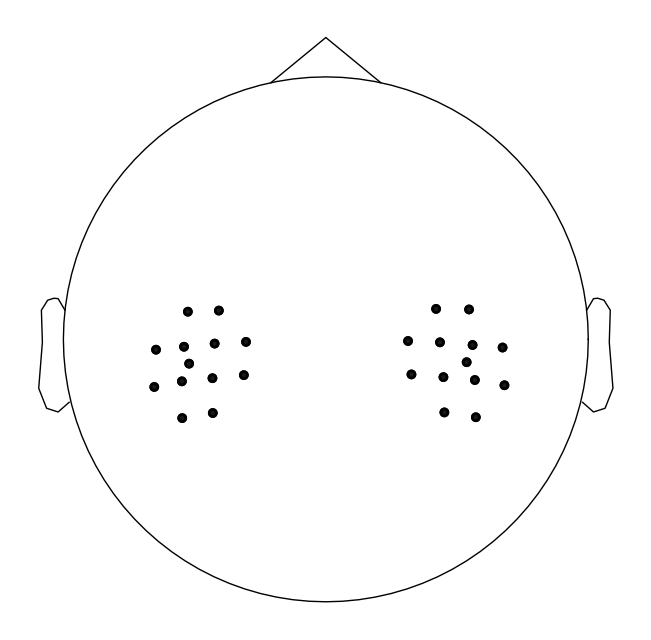

In [12]:
# Plot channels in 2D using build-in function of mne_nirs
sns.reset_defaults() # Turn of sns to be able to also plot contour of head
# dots = Center of channels
%matplotlib inline
raw_intensities[0].plot_sensors();

In [13]:
sns.set_theme()

---
> *Remark:*
- 24 long channels and 2 short channels
- 8 sources, 10 detectors and 2 short channel sources
- montage located above sensorimotor cortex
---

### Signal quality metrics and channel rejection <a class="anchor" id="section_1_3"></a>

#### Visual inspection <a class="anchor" id="sub_section_1_3_1"></a>

The quality of a fNIRS recording can be assessed by a visual inspection of the signals. On the one hand there can be features present in the signals which indicate a good signal quality, such as certain physiological components, and on the other hand there can be features present which indicate bad signal quality in one or more channels, such as MAs.

##### Visual inspection of the raw light intensity data

###### Subject 1

In [14]:
# Plot raw data with build-in plot function of mne_nirs
if plot:
    %matplotlib qt
    raw_intensities[0].plot(duration=300, show_scrollbars = True, clipping = None);

###### Subject 2

In [15]:
# Plot raw data with build-in plot function of mne_nirs
if plot:
    %matplotlib qt
    raw_intensities[1].plot(duration=300, show_scrollbars = True, clipping = None);

###### Subject 3

In [16]:
# Plot raw data with build-in plot function of mne_nirs
if plot:
    %matplotlib qt
    raw_intensities[2].plot(duration=300, show_scrollbars = True, clipping = None);

###### Subject 4

In [17]:
# Plot raw data with build-in plot function of mne_nirs
if plot:
    %matplotlib qt
    raw_intensities[3].plot(duration=300, show_scrollbars = True, clipping = None);

##### Visual inspection of the the optical density 

The OD or the attenuation of incident light, can be calculated as the logarithmic ratio of the input light intensity ($I_{in}$) and the detected light intensity ($I_{out}$):
$$OD_\lambda = \log \left(\frac{I_{in}}{I_{out}}\right)$$

In [18]:
# Convert raw intensity data to OD with build-in function of mne_nirs
raw_ods = []
for sub in range(4):
    raw_ods.append(optical_density(raw_intensities[sub]))

Reading 0 ... 6159  =      0.000 ...  1188.687 secs...


###### Subject 1

In [19]:
# Plot OD
if plot:
    %matplotlib qt
    raw_ods[0].plot(duration=300, show_scrollbars = True, clipping = None);

###### Subject 2

In [20]:
# Plot OD
if plot:
    %matplotlib qt
    raw_ods[1].plot(duration=300, show_scrollbars = True, clipping = None);

###### Subject 3

In [21]:
# Plot OD
if plot:
    %matplotlib qt
    raw_ods[2].plot(duration=300, show_scrollbars = True, clipping = None);

###### Subject 4

In [22]:
# Plot OD
if plot:
    %matplotlib qt
    raw_ods[3].plot(duration=300, show_scrollbars = True, clipping = None);

---
> *Remark:*
- For more information about the visual inspection procedure can be found in the **Signal quality metrics and channel rejection - FTT 2** Notebook.
---

##### Separate long and short channels

The short channels were not assessed using signal quality metrics because they inherently contain physiological noise. These channels cannot be removed from the dataset as they are essential for performing short channel regression.


In [23]:
raw_ods_full = []
raw_ods_short = []
raw_ods_new = []
min_dist = 0.01 
max_dist = 0.045
for sub in range(4):
    raw_ods_full.append(raw_ods[sub].copy())
    raw_ods_short.append(get_short_channels(raw_ods[sub], max_dist=min_dist))
    raw_ods_new.append(get_long_channels(raw_ods[sub], min_dist=min_dist, max_dist=max_dist))

In [24]:
raw_ods = raw_ods_new

In [25]:
# Short channels are: (channel number 16 and 17)
raw_ods_full[0].ch_names[32:36]

['S9_D1 760', 'S9_D1 850', 'S10_D2 760', 'S10_D2 850']

#### Scalp-coupling index <a class="anchor" id="sub_section_1_3_2"></a>

The SCI is a quality measurement of the connection between the optodes and the scalp of the participant using the strong cardiac oscillation in raw fNIRS signals. With a sufficiently high sampling rate (e.g.: 10 Hz), the heartbeat emerges as a dependable marker for evaluating optode-scalp coupling. It was first introduced by Pollonini et al. (2013) and it assesses the synchronous cardiac pulsation in the two photodetected signals (760 and 850 nm) in the cardiac band (0.5 - 2.5 Hz). After the bandpass-filtering the resulting signals are normalized to balance any difference between their amplitude. Finally, the zero-lag cross-correlation between photodetected signals of the same channel is used as a quantitative measure of the SNR of that specific channel. A threshold of SCI $>$ 0.75 is recommended by the authors.

Given that the frequency band of 0.5 - 2.5 Hz is quite broad and the participants are relatively at rest while seated, a FIR filter with a narrower band of 0.7 - 1.5 Hz is applied (40 bpm - 85 bpm). The transition band width at both the low and high cut-off frequencies is set to 0.3 Hz.

##### SCI evaluated over complete signal

In [90]:
# Calculate SCI with build-in function of mne_nirs
scis = []
for sub in range(4):
    scis.append(scalp_coupling_index(raw_ods[sub], l_freq=0.7, h_freq=1.5, l_trans_bandwidth=0.3, h_trans_bandwidth=0.3, verbose=False))
    # SCI bandpasses the signal with a FIR filter: l_freq=0.7, h_freq=1.5, l_trans_bandwidth=0.3, h_trans_bandwidth=0.3

In [91]:
# Copy raw object to apply SCI 
raw_od_SCIs = []
for sub in range(4):
    raw_od_SCIs.append(raw_ods[sub].copy())
# Mark channels with SCI < 0.75 as BAD
for sub in range(4):
    raw_od_SCIs[sub].info['bads'] = list(compress(raw_ods[sub].ch_names, scis[sub] < 0.75)) # 0.75 RECOMMENDED BY Pollonini et al. (2013)
    print('The ' + str(len(raw_od_SCIs[sub].info['bads'])) + ' bad channels for subject ' + str(sub+1) + ' are: ' + str(raw_od_SCIs[sub].info['bads']))

The 14 bad channels for subject 1 are: ['S3_D1 760', 'S3_D1 850', 'S7_D1 760', 'S7_D1 850', 'S6_D4 760', 'S6_D4 850', 'S7_D3 760', 'S7_D3 850', 'S2_D8 760', 'S2_D8 850', 'S1_D9 760', 'S1_D9 850', 'S7_D9 760', 'S7_D9 850']
The 16 bad channels for subject 2 are: ['S2_D2 760', 'S2_D2 850', 'S8_D2 760', 'S8_D2 850', 'S8_D4 760', 'S8_D4 850', 'S2_D8 760', 'S2_D8 850', 'S1_D9 760', 'S1_D9 850', 'S2_D10 760', 'S2_D10 850', 'S7_D9 760', 'S7_D9 850', 'S8_D10 760', 'S8_D10 850']
The 0 bad channels for subject 3 are: []
The 20 bad channels for subject 4 are: ['S1_D1 760', 'S1_D1 850', 'S3_D1 760', 'S3_D1 850', 'S5_D1 760', 'S5_D1 850', 'S7_D1 760', 'S7_D1 850', 'S8_D2 760', 'S8_D2 850', 'S8_D4 760', 'S8_D4 850', 'S1_D9 760', 'S1_D9 850', 'S2_D10 760', 'S2_D10 850', 'S7_D9 760', 'S7_D9 850', 'S8_D10 760', 'S8_D10 850']


##### SCI evaluated over moving window

Some extra channels are marked bad due to consistent bad scores over time (see **Signal quality metrics and channel rejection - FTT 2** Notebook).

In [92]:
# Add bad channels
raw_od_SCIs[2].info['bads'] += ['S6_D6 760', 'S6_D6 850']

In [93]:
# Add bad channels
raw_od_SCIs[3].info['bads'] += ['S2_D2 760', 'S2_D2 850']

---
> *Remark:*
- For more information about the scalp-oupling index procedure can be found in the **Signal quality metrics and channel rejection - FTT 2** Notebook.
---

#### Peak spectral power <a class="anchor" id="sub_section_1_3_3"></a>

Pollonini et al. (2016) state that to enhance the reliability of a quantitative measure for scalp coupling, the spectral power of the cross-correlated signal can serve as an additional indicator of cardiac signal strength. By setting a spectral power threshold, it becomes possible to objectively differentiate between a clear optical channel and a noisy one. Theoretically, photodetected cardiac signals can be conceptualized as two sinusoidal waves oscillating at the physiological frequency $f_{cardiac}$ (e.g.: 1 Hz or 60 bpm) with arbitrary amplitude and offset. The resultant normalized cross-correlation signal ($\overline{x_{\lambda_1}}  \otimes \overline{x_{\lambda_2}}$) exhibits unity amplitude, a frequency of $f_{cardiac}$ and a peak power of 0.5. Therefore, a threshold can be established at a certain fraction of the ideal peak power. However, in practice, cardiac photoplethysmographic signals are not strictly sinusoidal and may contain quantization noise, which reduces the peak power value. Hence, the authors recommend empirically setting the threshold value at 0.1.

In [94]:
# View instances where a subset of channels may be contaminated by artifacts for a short duration of the recording
raw_od_SCI_PSPs = []
for sub in range(4):
    raw_od_SCI_PSP, scores, times = peak_power(raw_od_SCIs[sub], time_window=10)
    raw_od_SCI_PSPs.append(raw_od_SCI_PSP)

---
> *Remark:*
- For more information about the peak spectral power procedure can be found in the **Signal quality metrics and channel rejection - FTT 2** Notebook.
---

##### Check if signal quality assesment was performed well

###### Subject 1

In [31]:
# Plot OD
if plot:
    %matplotlib qt
    raw_od_SCI_PSPs[0].plot(duration=300, show_scrollbars = True, clipping = None);

###### Subject 2

In [32]:
# Plot OD
if plot:
    %matplotlib qt
    raw_od_SCI_PSPs[1].plot(duration=300, show_scrollbars = True, clipping = None);

###### Subject 3

In [33]:
# Plot OD
if plot:
    %matplotlib qt
    raw_od_SCI_PSPs[2].plot(duration=300, show_scrollbars = True, clipping = None);

###### Subject 4

In [34]:
# Plot OD
if plot:
    %matplotlib qt
    raw_od_SCI_PSPs[3].plot(duration=300, show_scrollbars = True, clipping = None);

---
> *Remark:*
- Some time segments are marked manually as bad
- Selection of channels marked as bad through SCI
- Peak spectral power marked time segments in selected channels bad
---

### Motion artefact correction <a class="anchor" id="section_1_4"></a>

#### Temporal derivative distribution repair <a class="anchor" id="sub_section_1_4_1">

The TDDR method was introduced by Fishburn et al. in 2019. It offers both online and offline filtering approaches based on the temporal derivative of fNIRS signals, requiring no user-defined parameters. Moreover, it is applicable to concentration changes, optical intensities, and optical densities (Huang et al., 2022).

This method operates under specific assumptions: (1) non-motion-related fluctuations follow a normal distribution, (2) the majority of fluctuations are unrelated to motion artifacts, and (3) MA derivatives dominate in the derivatives of fNIRS signals during their presence.

The algorithm comprises five distinct steps. Fishburn et al. (2019) provides an in-depth description of each step.

##### Perform TDDR on OD data

In [95]:
# Add short channels again
for sub in range(4):
    raw_od_SCIs[sub].add_channels([raw_ods_short[sub]])

In [96]:
raw_ods_TDDR = []
for sub in range(4):
    raw_ods_TDDR.append(temporal_derivative_distribution_repair(raw_od_SCIs[sub]))

##### Visualize results

##### Subject 1

In [37]:
if plot:
    compare_original_filtered(raw_ods_TDDR[0], raw_ods_full[0], export = export, filename = 'TDDR/Subject_1')

###### Subject 2

In [38]:
if plot:
    compare_original_filtered(raw_ods_TDDR[1], raw_ods_full[1], export = export, filename = 'TDDR/Subject_2')

###### Subject 3

In [39]:
if plot:
    compare_original_filtered(raw_ods_TDDR[2], raw_ods_full[2], export = export, filename = 'TDDR/Subject_3')

###### Subject 4

In [40]:
if plot:
    compare_original_filtered(raw_ods_TDDR[3], raw_ods_full[3], export = export, filename = 'TDDR/Subject_4')

In [41]:
raw_ods_TDDR[3].ch_names[4]

'S3_D1 760'

---
> *Remark:*
- TDDR succeeds in removing most spikes
- Baseline drifts are still present
- Amplitude of some channels is changed
---

### Short channel regression <a class="anchor" id="section_1_5"></a>

#### Method of Saager and Berger <a class="anchor" id="sub_section_1_5_1"></a>

The reflectance measurements at two detectors, L and S, allow for the calculation of absorbance changes $\Delta A_L (t)$ and $\Delta A_S (t)$. To eliminate the influence of the superficial component of the probed tissue, measurements can be taken using two SDD: long and short. This can be achieved using the equation:
$$ \Delta A_C (\lambda, t) = \Delta A_L (\lambda, t) - \alpha \cdot \Delta A_S (\lambda, t)$$

Here, $\Delta A_C (\lambda, t)$ represents the corrected attenuation, $\Delta A_L (\lambda, t)$ corresponds to the attenuation at the long SDD (sampling both brain and superficial components), and $\Delta A_S (\lambda, t)$ pertains to the short SDD (sampling only superficial components) (Scholkmann et al., 2014). 

According to Saager and Berger (2005), the scaling parameter $\alpha$ can be determined directly using a least-squares method:

$$\alpha = \frac{\Delta A_S (\lambda, t) \cdot \Delta A_L (\lambda, t)}{\Delta A_S (\lambda, t) \cdot \Delta A_S (\lambda, t)}$$


In [97]:
# Short channels predominantly contain systemic responses and long channels have both neural and systemic contribution
raw_ods_SCR = []
for sub in range(4):
    raw_ods_SCR.append(short_channel_regression(raw_ods_TDDR[sub].copy(), max_dist=min_dist))

##### Visualize result

###### Subject 1

In [43]:
if plot:
    compare_original_filtered(raw_ods_SCR[0], raw_ods_TDDR[0], export = export, filename = 'SCR/Subject_1')

###### Subject 2

In [44]:
if plot:
    compare_original_filtered(raw_ods_SCR[1], raw_ods_TDDR[1], export = export, filename = 'SCR/Subject_2')

###### Subject 3

In [45]:
if plot:
    compare_original_filtered(raw_ods_SCR[2], raw_ods_TDDR[2], export = export, filename = 'SCR/Subject_3')

###### Subject 4

In [46]:
if plot:
    compare_original_filtered(raw_ods_SCR[3], raw_ods_TDDR[3], export = export, filename = 'SCR/Subject_4')

##### Detailed view

S3_D1 850
S9_D1 850


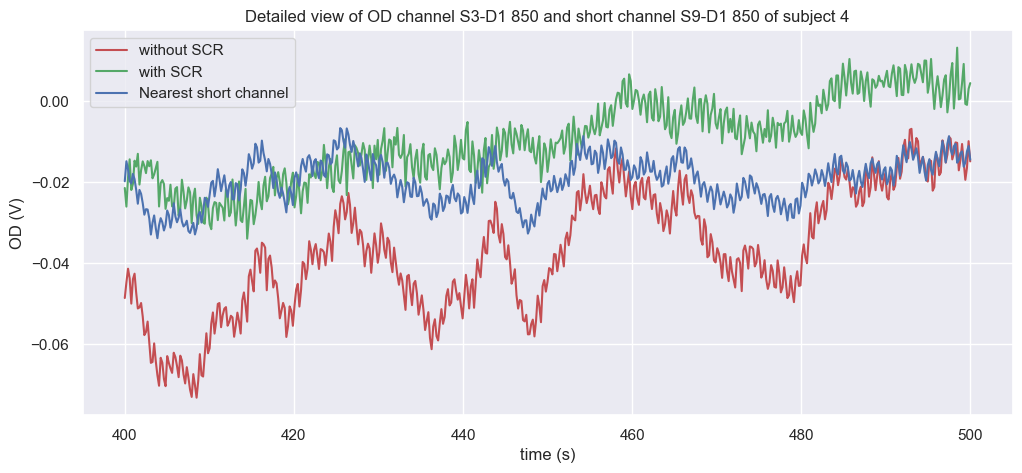

In [80]:
%matplotlib inline
sub = 2 # subject number - 1
chan = 5 # channel pick
chan_short = 49 # short channel pick (closest to long channel and same wavelength)
print(raw_ods_TDDR[sub].ch_names[chan])
print(raw_ods_TDDR[sub].ch_names[chan_short])
tmin, tmax = 400, 500
data_no_SCR = raw_ods_TDDR[sub].copy().pick(chan).crop(tmin,tmax).get_data()[0]
data_SCR = raw_ods_SCR[sub].copy().pick(chan).crop(tmin,tmax).get_data()[0]
data_SC = raw_ods_TDDR[sub].copy().pick(chan_short).crop(tmin,tmax).get_data()[0]
t = np.arange(len(data_no_SCR))/raw_ods[sub].info['sfreq'] + tmin
fig = plt.figure(figsize = (12,5))
plt.plot(t, data_no_SCR, label = 'without SCR', color = 'r')
plt.plot(t, data_SCR, label = 'with SCR', color = 'g')
plt.plot(t, data_SC, label = 'Nearest short channel', color = 'b')
plt.xlabel('time (s)')
plt.ylabel('OD (V)')
plt.title('Detailed view of OD channel S3-D1 850 and short channel S9-D1 850 of subject 4')
plt.legend()
if export:
    fig.savefig('SCR_subject_4.png')

---
> *Remark:*
- Baseline drifts are partially removed
- Large oscillation due to physiological noise partially removed
- Heart beat still present 
---

### Global component derived from the mean or median <a class="anchor" id="section_1_6"></a>

It is worth noting that the short channel regression techniques discussed earlier can also be adapted by using the global component derived from the mean or median of all channels. This approach estimates systemic physiological changes common across channels and filters them from each channel, further improving the isolation of neural signals.

#### Method of Saager and Berger <a class="anchor" id="sub_section_1_6_1"></a>

In [48]:
# Based on code of mne_nirs.signal_enhancement._short_channel_correction
def M_regression_SB(raw, min_dist = 0.01, max_dist=0.045, method = 'mean'):
    raw = raw.copy()

    picks_od = mne.pick_types(raw.info, fnirs='fnirs_od')

    if len(picks_od) == 0:
        raise RuntimeError('Data must be optical density.')
    
    distances = source_detector_distances(raw.info)
    picks_long = picks_od[distances[picks_od] > min_dist]

    Y_long = get_long_channels(raw, min_dist=min_dist, max_dist=max_dist).get_data()
    m = np.zeros((2, Y_long.shape[1]))
    
    if method == 'mean':
        m[0] = np.mean(Y_long[::2], axis = 0) # 760 wavelength
        m[1] = np.mean(Y_long[1::2], axis = 0) # 850 wavelength
    elif method == 'median':
        m[0] = np.median(Y_long[::2], axis = 0) # 760 wavelength
        m[1] = np.median(Y_long[1::2], axis = 0) # 850 wavelength


    for pick in picks_long:
        i = pick%2
        A_l = raw.get_data(pick).ravel()
        A_s = m[i].ravel()

        # Eqn 27 Scholkmann et al 2014
        alfa = np.dot(A_s, A_l) / np.dot(A_s, A_s)

        # Eqn 26 Scholkmann et al 2014
        raw._data[pick] = A_l - alfa * A_s

    return raw

##### Estimate global component derived from the mean

In [49]:
# This approach estimates systemic physiological changes common across channels and filters them from each channel
raw_ods_MeanCR = []
for sub in range(4):
    raw_ods_MeanCR.append(M_regression_SB(raw_ods_TDDR[sub].copy(), min_dist=min_dist, method = 'mean'))

##### Visualize result

##### Subject 1

In [50]:
if plot:
    compare_original_filtered(raw_ods_MeanCR[0], raw_ods_TDDR[0], export = export, filename = 'MeanCR/Subject_1')

##### Subject 2

In [51]:
if plot:
    compare_original_filtered(raw_ods_MeanCR[1], raw_ods_TDDR[1], export = export, filename = 'MeanCR/Subject_2')

##### Subject 3

In [52]:
if plot:
    compare_original_filtered(raw_ods_MeanCR[2], raw_ods_TDDR[2], export = export, filename = 'MeanCR/Subject_3')

##### Subject 4

In [53]:
if plot:
    compare_original_filtered(raw_ods_MeanCR[3], raw_ods_TDDR[3], export = export, filename = 'MeanCR/Subject_4')

##### Estimate global component derived from the median

In [54]:
# This approach estimates systemic physiological changes common across channels and filters them from each channel
raw_ods_MedianCR = []
for sub in range(4):
    raw_ods_MedianCR.append(M_regression_SB(raw_ods_TDDR[sub].copy(), min_dist=min_dist, method = 'median'))

##### Visualize results

###### Subject 1

In [55]:
if plot:
    compare_original_filtered(raw_ods_MedianCR[0], raw_ods_TDDR[0], export = export, filename = 'MedianCR/Subject_1')

###### Subject 2

In [56]:
if plot:
    compare_original_filtered(raw_ods_MedianCR[1], raw_ods_TDDR[1], export = export, filename = 'MedianCR/Subject_2')

###### Subject 3

In [57]:
if plot:
    compare_original_filtered(raw_ods_MedianCR[2], raw_ods_TDDR[2], export = export, filename = 'MedianCR/Subject_3')

###### Subject 4

In [58]:
if plot:
    compare_original_filtered(raw_ods_MedianCR[3], raw_ods_TDDR[3], export = export, filename = 'MedianCR/Subject_4')

---
> *Remark:*
- Both techniques yield results similar to those obtained using the SCR.
---

### Signal processing methods <a class="anchor" id="section_1_7"></a>

#### Bandpass filtering <a class="anchor" id="sub_section_1_7_1"></a>

Bandpass filtering is a common technique used in fNIRS research to remove both high-frequency components, such as instrument noise and cardiac pulsations, and low-frequency components from the signal. The filter characteristics significantly influence the filtered data, so it is crucial to specify the type of filtering applied, the filter order, and the cutoff frequencies (Yucel et al., 2021). 

When choosing the filter type, considering the phase response is important, as filters with a nonlinear phase response can distort the signal or cause phase shifts across the frequency band. Finite impulse response (FIR) filters, which have linear phase responses, can be safely applied both offline and online (during data collection). In contrast, infinite impulse response (IIR) filters (e.g.: Butterworth) require zero-phase correction, necessitating the entire signal at once, and therefore can only be applied offline. Additionally, FIR filters are more stable and easier to control than IIR filters, ensuring that the output remains finite (Yucel et al., 2021).

Following the guidelines of Pinti et al. (2019), a FIR bandpass filter with order 1000, low cut-off frequency $F_{c, low} = 0.01 Hz$ and a high cut-off frequency $f_{experiment} < f_{c, high} < f_{Mayer-wave}$ will be performed on the haemodynamic data.

##### Convert OD data to haemodynamic data

By solving the Beer-Lambert law for two measurement wavelengths on either side of the isosbestic point - the point where the HbR and HbO spectra cross, the unknows can be eliminated from the equation. Small changes of attenuation for both wavelengths, due to changes in  HbR and HbO concentrations, can be detected with the following formula:
$$ \Delta OD_\lambda = \log \left(\frac{I_{rest}}{I_{test}}\right) \ \approx \epsilon_\lambda^{HbR} \cdot \Delta c^{HbR} \cdot L + \epsilon_\lambda^{HbO} \cdot \Delta c^{HbO} \cdot L $$
From the two resulting equations, one for each wavelength, the chromophore concentrations can be found:
$$ [HbO] = \frac{a_{HbO}^{\lambda_2} \cdot \Delta A_{\lambda_1} - a_{HbR}^{\lambda_1} \cdot \Delta A_{\lambda_2}}{L \cdot (a_{HbO}^{\lambda_1} \cdot a_{HbR}^{\lambda_2} - a_{HbO}^{\lambda_2} \cdot a_{HbR}^{\lambda_1})} $$
$$ [HbR] = \frac{a_{HbO}^{\lambda_1} \cdot \Delta A_{\lambda_2} - a_{HbR}^{\lambda_2} \cdot \Delta A_{\lambda_1}}{L \cdot (a_{HbO}^{\lambda_1} \cdot a_{HbR}^{\lambda_2} - a_{HbO}^{\lambda_2} \cdot a_{HbR}^{\lambda_1})}$$

In [2]:
# Convert OD to haemoglobin concentration with build-in function of mne_nirs
# Constant ppf value: PPF = DPF/PVC
raw_haemos_short = []
raw_haemos = []
for sub in range(4):
    raw_haemo = beer_lambert_law(raw_ods_SCR[sub], ppf=6) # ppf=6 is more inline with the community expectations and makes our results easier compared to the majority of the existing literature.
    raw_haemos_short.append(get_short_channels(raw_haemo, max_dist=min_dist)) 
    raw_haemos.append(get_long_channels(raw_haemo, min_dist=min_dist, max_dist=max_dist))

NameError: name 'beer_lambert_law' is not defined

##### Model neural response

In [100]:
def plot_neural_response(raw_input, stim_names, stim_duration, f_experiment = None, export = None, subject = None):
    """
    Based on MNE-NIRS tutorials
    """
    %matplotlib inline
    design_matrix = make_first_level_design_matrix(raw_input, drift_order=0, stim_dur=stim_duration)
    hrf_hbo = raw_input.copy().pick(picks=[0])
    hrf_hbr = raw_input.copy().pick(picks=[1])
    for stim_name in stim_names:
        hrf_hbo._data[0] = 1e-6 * design_matrix[stim_name].T # HbO
        hrf_hbr._data[0] = -5e-7 * design_matrix[stim_name].T # HbR: Half amplitude and negative 
    fig_hbo = hrf_hbo.pick(picks='hbo').compute_psd().plot(average=True, xscale='log', color='r', show=False)
    plt.vlines(f_experiment, 20, -120, 'r', label = 'f_experiment: ' + str(round(f_experiment,3)) + ' Hz')
    plt.legend()
    plt.title('Neural response HbO subject ' + str(sub+1))
    plt.show()
    fig_hbr = hrf_hbr.pick(picks='hbr').compute_psd().plot(average=True, xscale='log', color='r', show=False)
    plt.vlines(f_experiment, 20, -120, 'r', label = 'f_experiment: ' + str(round(f_experiment,3)) + ' Hz')
    plt.legend()
    plt.title('Neural response HbR subject ' + str(sub+1))
    plt.show()
    if export:
        fig_hbo.savefig('NR/Neural response_FTT2_HbO_subject_' + str(sub+1) + '.png')
        fig_hbr.savefig('NR/Neural response_FTT2_HbR_subject_' + str(sub+1) + '.png')

Used stimuli: ['test/LEFT', 'test/RIGHT']
f_experiment: 0.02857142857142857
Effective window size : 395.264 (s)
Plotting power spectral density (dB=True).


C:\Users\fabia\AppData\Local\Temp\ipykernel_12440\214834406.py:12: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  fig_hbo = hrf_hbo.pick(picks='hbo').compute_psd().plot(average=True, xscale='log', color='r', show=False)


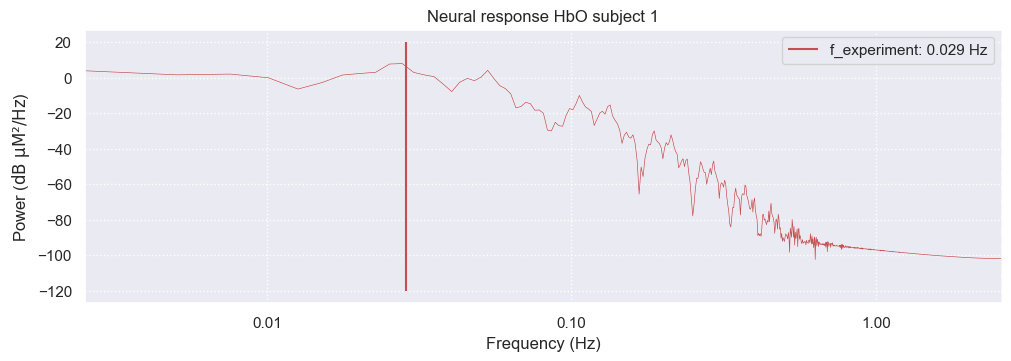

Effective window size : 395.264 (s)
Plotting power spectral density (dB=True).


C:\Users\fabia\AppData\Local\Temp\ipykernel_12440\214834406.py:17: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  fig_hbr = hrf_hbr.pick(picks='hbr').compute_psd().plot(average=True, xscale='log', color='r', show=False)


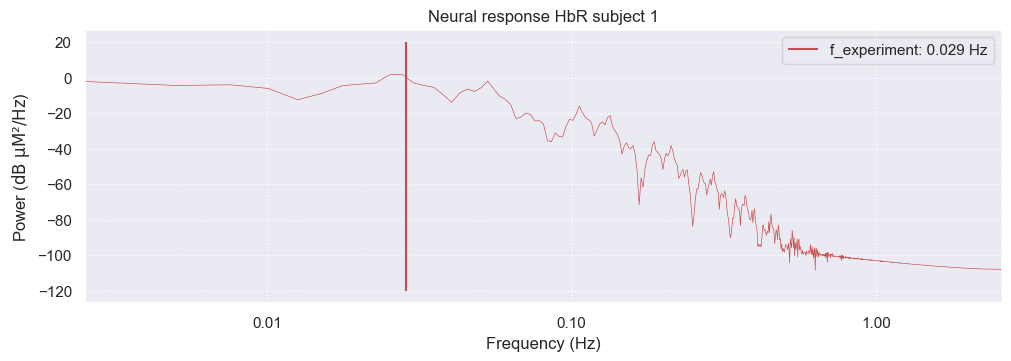

Effective window size : 395.264 (s)
Plotting power spectral density (dB=True).


C:\Users\fabia\AppData\Local\Temp\ipykernel_12440\214834406.py:12: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  fig_hbo = hrf_hbo.pick(picks='hbo').compute_psd().plot(average=True, xscale='log', color='r', show=False)


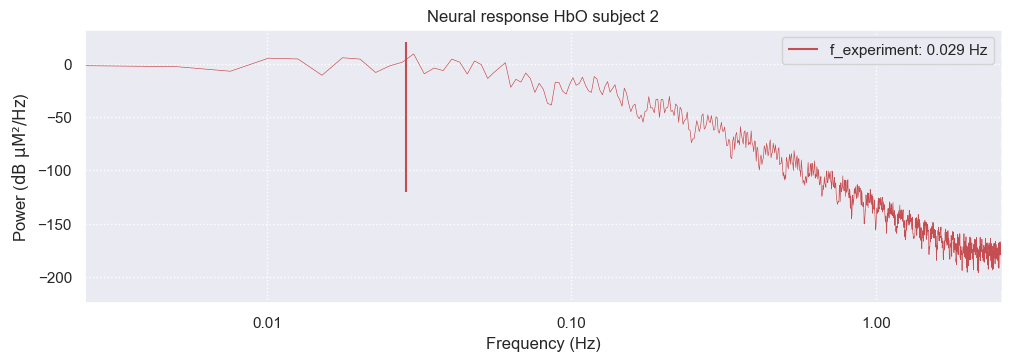

Effective window size : 395.264 (s)
Plotting power spectral density (dB=True).


C:\Users\fabia\AppData\Local\Temp\ipykernel_12440\214834406.py:17: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  fig_hbr = hrf_hbr.pick(picks='hbr').compute_psd().plot(average=True, xscale='log', color='r', show=False)


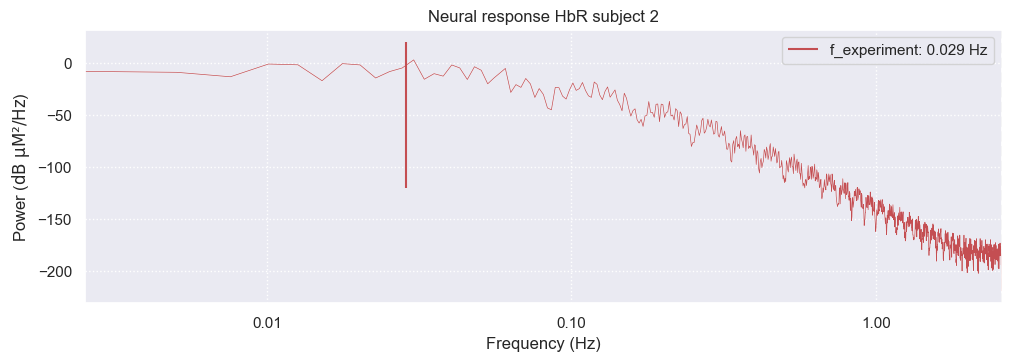

Effective window size : 395.264 (s)
Plotting power spectral density (dB=True).


C:\Users\fabia\AppData\Local\Temp\ipykernel_12440\214834406.py:12: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  fig_hbo = hrf_hbo.pick(picks='hbo').compute_psd().plot(average=True, xscale='log', color='r', show=False)


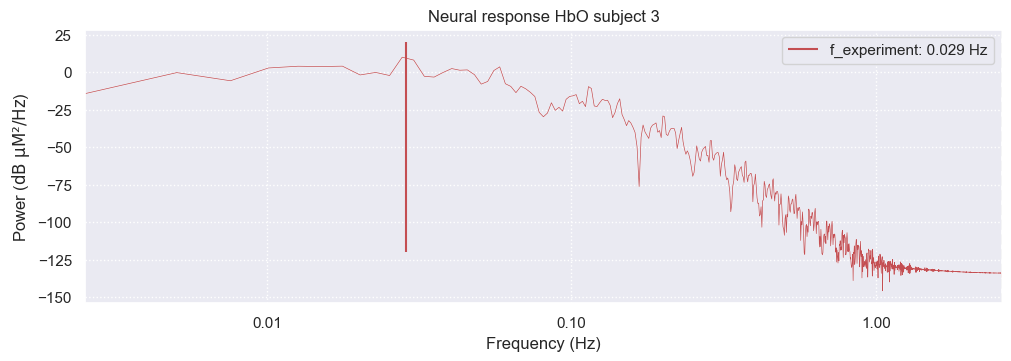

Effective window size : 395.264 (s)
Plotting power spectral density (dB=True).


C:\Users\fabia\AppData\Local\Temp\ipykernel_12440\214834406.py:17: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  fig_hbr = hrf_hbr.pick(picks='hbr').compute_psd().plot(average=True, xscale='log', color='r', show=False)


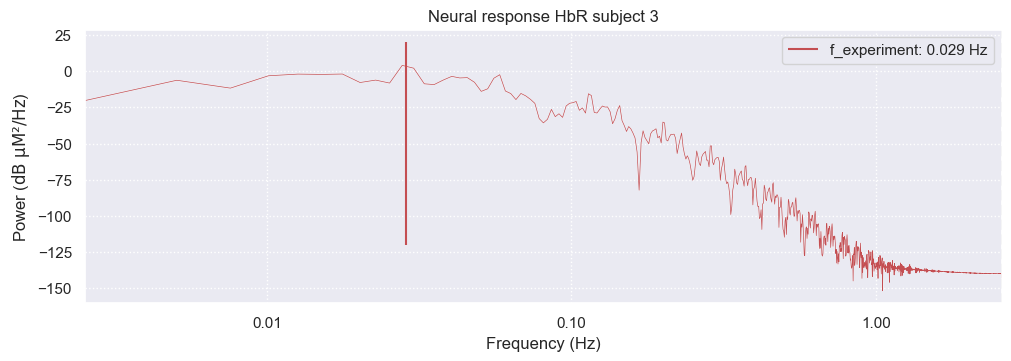

Effective window size : 395.264 (s)
Plotting power spectral density (dB=True).


C:\Users\fabia\AppData\Local\Temp\ipykernel_12440\214834406.py:12: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  fig_hbo = hrf_hbo.pick(picks='hbo').compute_psd().plot(average=True, xscale='log', color='r', show=False)


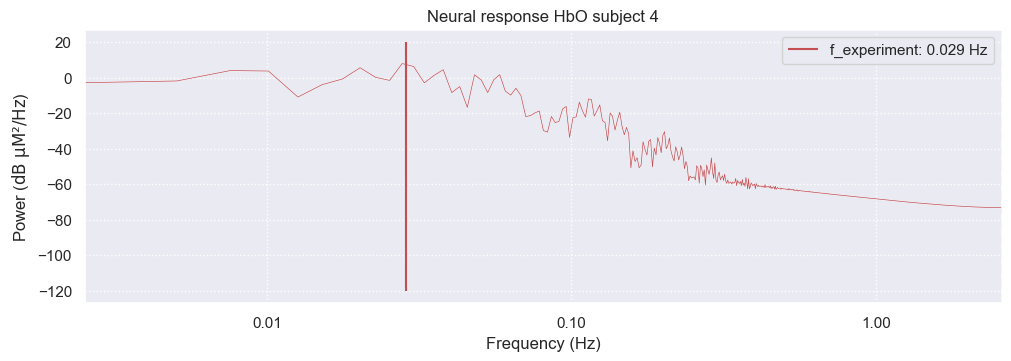

Effective window size : 395.264 (s)
Plotting power spectral density (dB=True).


C:\Users\fabia\AppData\Local\Temp\ipykernel_12440\214834406.py:17: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  fig_hbr = hrf_hbr.pick(picks='hbr').compute_psd().plot(average=True, xscale='log', color='r', show=False)


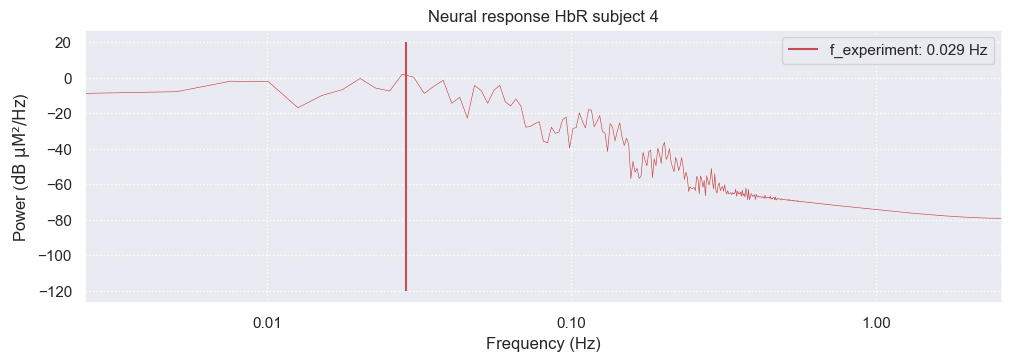

In [122]:
# Create the expected model neural response function using the data and plot the frequency spectrum.
stim_duration = 12
interstimDur = 23
stim_names = list(event_dicts[0].keys())[3:]
print('Used stimuli: ' + str(stim_names))
f_experiment = 1/(stim_duration+interstimDur) # 12 s task duration and 23 s inter-stimulus interval
print('f_experiment: ' + str(f_experiment))
for sub in range(4):
    plot_neural_response(raw_haemos[sub], stim_names, stim_duration, f_experiment, export = export, subject = sub)

---
> *Remark:*
- This is the expected PSD based on the HRF model linked to the stimuli onsets of the grasping tasks ('test/LEFT', 'test/RIGHT')
- The red vertical line indicates the frequency of the stimuli (1 over sum of duration stimulus and inter-stimulis duration)
- Peak expected around this task frequency 
---

##### Plot the PSD of raw measured data

Effective window size : 395.264 (s)
Plotting power spectral density (dB=True).


C:\Users\fabia\AppData\Local\Temp\ipykernel_12440\426159529.py:3: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  fig = raw_haemos[sub].compute_psd().plot(average=True, exclude="bads", xscale='log')
C:\Users\fabia\AppData\Roaming\Python\Python311\site-packages\mne\viz\utils.py:167: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


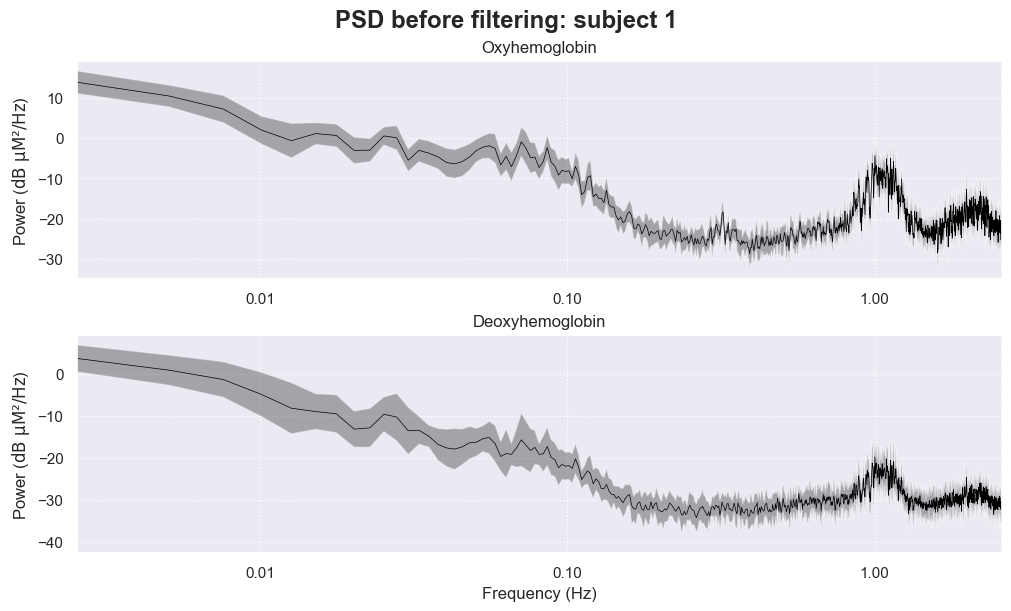

Effective window size : 395.264 (s)
Plotting power spectral density (dB=True).


C:\Users\fabia\AppData\Local\Temp\ipykernel_12440\426159529.py:3: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  fig = raw_haemos[sub].compute_psd().plot(average=True, exclude="bads", xscale='log')
C:\Users\fabia\AppData\Roaming\Python\Python311\site-packages\mne\viz\utils.py:167: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


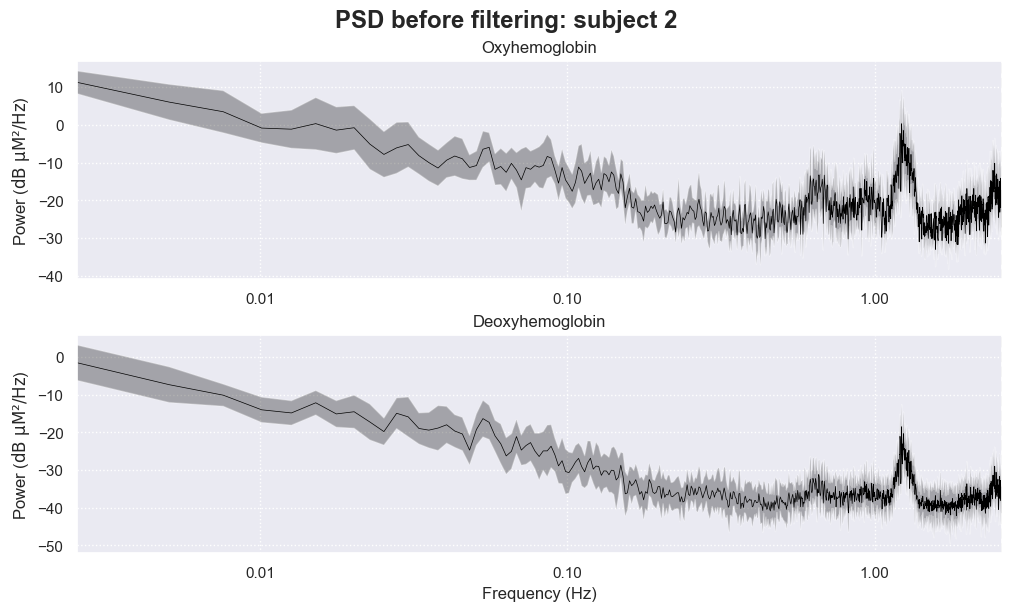

Effective window size : 395.264 (s)
Plotting power spectral density (dB=True).


C:\Users\fabia\AppData\Local\Temp\ipykernel_12440\426159529.py:3: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  fig = raw_haemos[sub].compute_psd().plot(average=True, exclude="bads", xscale='log')
C:\Users\fabia\AppData\Roaming\Python\Python311\site-packages\mne\viz\utils.py:167: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


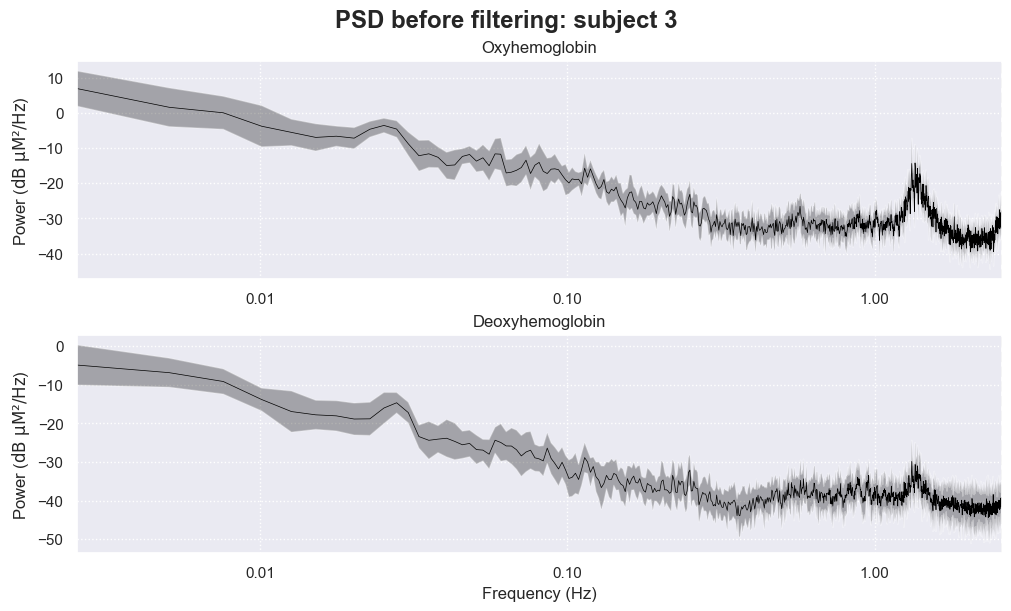

Effective window size : 395.264 (s)
Plotting power spectral density (dB=True).


C:\Users\fabia\AppData\Local\Temp\ipykernel_12440\426159529.py:3: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  fig = raw_haemos[sub].compute_psd().plot(average=True, exclude="bads", xscale='log')
C:\Users\fabia\AppData\Roaming\Python\Python311\site-packages\mne\viz\utils.py:167: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


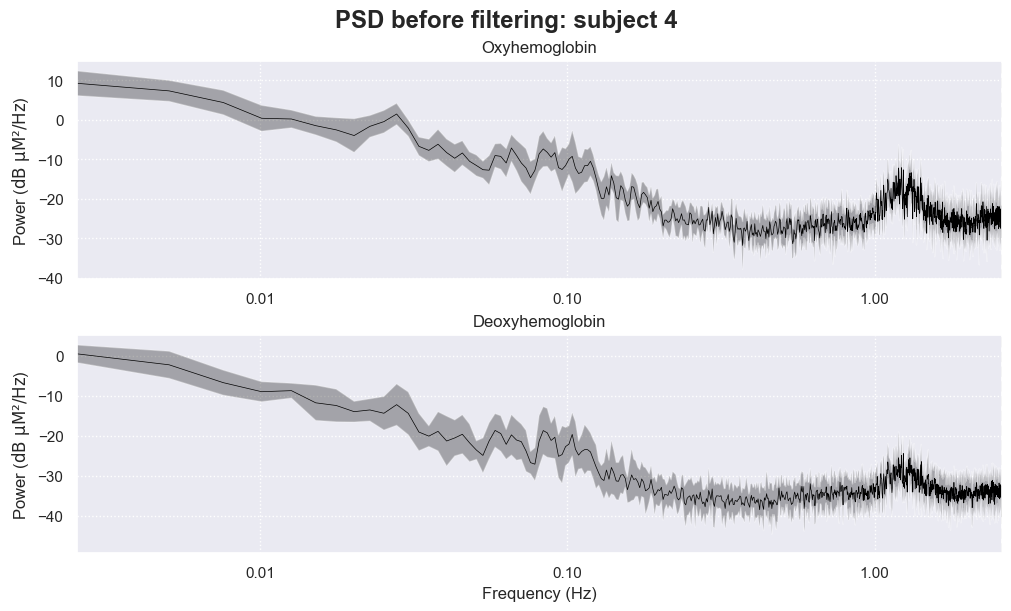

In [102]:
%matplotlib inline
for sub in range(4):
    fig = raw_haemos[sub].compute_psd().plot(average=True, exclude="bads", xscale='log')
    fig.suptitle('PSD before filtering: subject ' + str(sub+1), weight='bold', size='x-large');
    if export:
        fig.savefig('PSD/PSD_before_filetring_subject_' + str(sub+1) + '.png')

    plt.show()

##### Plot filter response

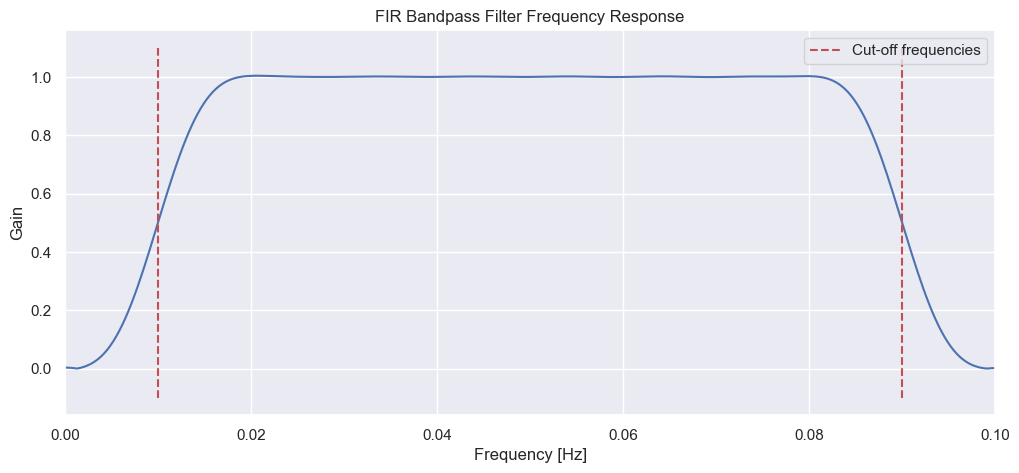

In [103]:
# Specifications
order = 1000
sample_rate = raw_haemos[0].info['sfreq']  # Example sample rate in Hz
nyquist_rate = sample_rate / 2.0
cutoff_freqs = [0.01, 0.09]  # Cut-off frequencies in Hz

# Normalize the cut-off frequencies to Nyquist frequency
normalized_cutoff = [f / nyquist_rate for f in cutoff_freqs]

# Design the FIR bandpass filter using firwin
fir_coefficients = firwin(order + 1, normalized_cutoff, pass_zero='bandpass')

# Plot the frequency response
w, h = freqz(fir_coefficients, worN=8000)
plt.figure(figsize=(12,5))
plt.plot(0.5 * sample_rate * w / np.pi, np.abs(h), 'b')
plt.title('FIR Bandpass Filter Frequency Response')
plt.xlabel('Frequency [Hz]')
#plt.xscale('log')
plt.ylabel('Gain')
plt.xlim((0,0.1))
plt.vlines(cutoff_freqs, -0.1, 1.1, linestyle = '--', color = 'r',  label = 'Cut-off frequencies')
plt.legend()
if export:
    plt.savefig('FIR_BPF_response_FTT2.png')
plt.show()

##### Plot filtered signal

In [104]:
def BPF(raw_input, fir_coefficients, sample_rate, plot = False, export = False, filename = None):

    raw_ = raw_input.copy()
    data = raw_.get_data()
    picks = np.sort(_validate_nirs_info(raw_.info))

    for pick in picks:
        signal = data[pick]
        filtered_signal = filtfilt(fir_coefficients, 1.0, signal) # Zero phase filtering (Can only be done offline)
        
        raw_._data[pick] = filtered_signal
    
    if plot:
        compare_original_filtered(raw_, raw_input, export = export, filename = filename)
    
    return raw_

###### Subject 1

In [105]:
raw_haemos_filtered = []
raw_haemos_filtered.append(BPF(raw_haemos[0], fir_coefficients, sample_rate, plot = plot, export = export, filename = 'BPF/FTT2_BPF_subject_1'))

###### Subject 2

In [106]:
raw_haemos_filtered.append(BPF(raw_haemos[1], fir_coefficients, sample_rate, plot = plot, export = export, filename = 'BPF/FTT2_BPF_subject_2'))

###### Subject 3 

In [107]:
raw_haemos_filtered.append(BPF(raw_haemos[2], fir_coefficients, sample_rate, plot = plot, export = export, filename = 'BPF/FTT2_BPF_subject_3'))

###### Subject 4

In [108]:
raw_haemos_filtered.append(BPF(raw_haemos[3], fir_coefficients, sample_rate, plot = plot, export = export, filename = 'BPF/FTT2_BPF_subject_4'))

S4_D2 hbo


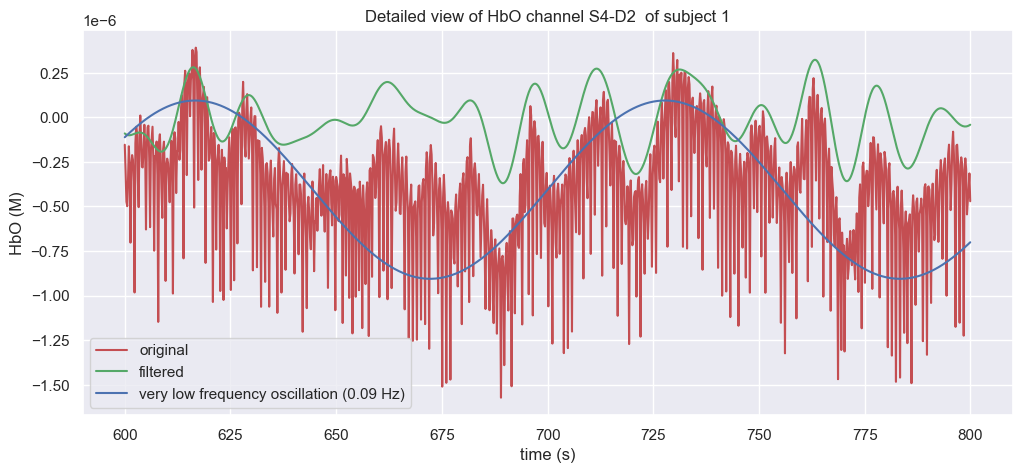

In [109]:
# Detailed view
%matplotlib inline
sub = 0 # subject number - 1
chan = 6 # channel pick
print(raw_haemos[sub].ch_names[chan])
tmin, tmax = 600, 800
data_no_BPF = raw_haemos[sub].copy().pick(chan).crop(tmin,tmax).get_data()[0]
data_BPF = raw_haemos_filtered[sub].copy().pick(chan).crop(tmin,tmax).get_data()[0]
t = np.arange(len(data_BPF))/raw_haemos[sub].info['sfreq'] + tmin
VLFO = 5e-7*np.sin(2 * np.pi * 0.009 * t + 1.4 * np.pi) + np.mean(data_no_BPF)
fig = plt.figure(figsize = (12,5))
plt.plot(t, data_no_BPF, label = 'original', color = 'r')
plt.plot(t, data_BPF, label = 'filtered', color = 'g')
plt.plot(t, VLFO, label = 'very low frequency oscillation (0.09 Hz)', color = 'b')
plt.xlabel('time (s)')
plt.ylabel('HbO (M)')
plt.title('Detailed view of HbO channel S4-D2  of subject 1')
plt.legend()
if export:
    fig.savefig('Detail_BPF_subject_1.png')

In [110]:
# Possible transient delay if not implementing zero-phase filtering
transient_length = order//2
transient_time = transient_length/sample_rate
print('Due to the high order of the filter there is possibly a large transient part of ' + str(transient_time) + ' seconds [' + str(transient_length) + ' samples]')

Due to the high order of the filter there is possibly a large transient part of 96.5 seconds [500 samples]


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 395.264 (s)
Plotting power spectral density (dB=True).
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 395.264 (s)
Plotting power spectral density (dB=True).


C:\Users\fabia\AppData\Local\Temp\ipykernel_12440\3058167736.py:2: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  fig = raw_haemos[sub].plot_psd(average=True, fmax=2, xscale='log', color='k', show=False);
C:\Users\fabia\AppData\Local\Temp\ipykernel_12440\3058167736.py:3: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  raw_haemos_filtered[sub].plot_psd(average=True, fmax=2, xscale='log', ax=fig.axes, color='g', show=False);


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 395.264 (s)
Plotting power spectral density (dB=True).
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 395.264 (s)
Plotting power spectral density (dB=True).


C:\Users\fabia\AppData\Local\Temp\ipykernel_12440\3058167736.py:2: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  fig = raw_haemos[sub].plot_psd(average=True, fmax=2, xscale='log', color='k', show=False);
C:\Users\fabia\AppData\Local\Temp\ipykernel_12440\3058167736.py:3: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  raw_haemos_filtered[sub].plot_psd(average=True, fmax=2, xscale='log', ax=fig.axes, color='g', show=False);


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 395.264 (s)
Plotting power spectral density (dB=True).
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 395.264 (s)
Plotting power spectral density (dB=True).


C:\Users\fabia\AppData\Local\Temp\ipykernel_12440\3058167736.py:2: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  fig = raw_haemos[sub].plot_psd(average=True, fmax=2, xscale='log', color='k', show=False);
C:\Users\fabia\AppData\Local\Temp\ipykernel_12440\3058167736.py:3: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  raw_haemos_filtered[sub].plot_psd(average=True, fmax=2, xscale='log', ax=fig.axes, color='g', show=False);


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 395.264 (s)
Plotting power spectral density (dB=True).
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 395.264 (s)
Plotting power spectral density (dB=True).


C:\Users\fabia\AppData\Local\Temp\ipykernel_12440\3058167736.py:2: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  fig = raw_haemos[sub].plot_psd(average=True, fmax=2, xscale='log', color='k', show=False);
C:\Users\fabia\AppData\Local\Temp\ipykernel_12440\3058167736.py:3: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  raw_haemos_filtered[sub].plot_psd(average=True, fmax=2, xscale='log', ax=fig.axes, color='g', show=False);


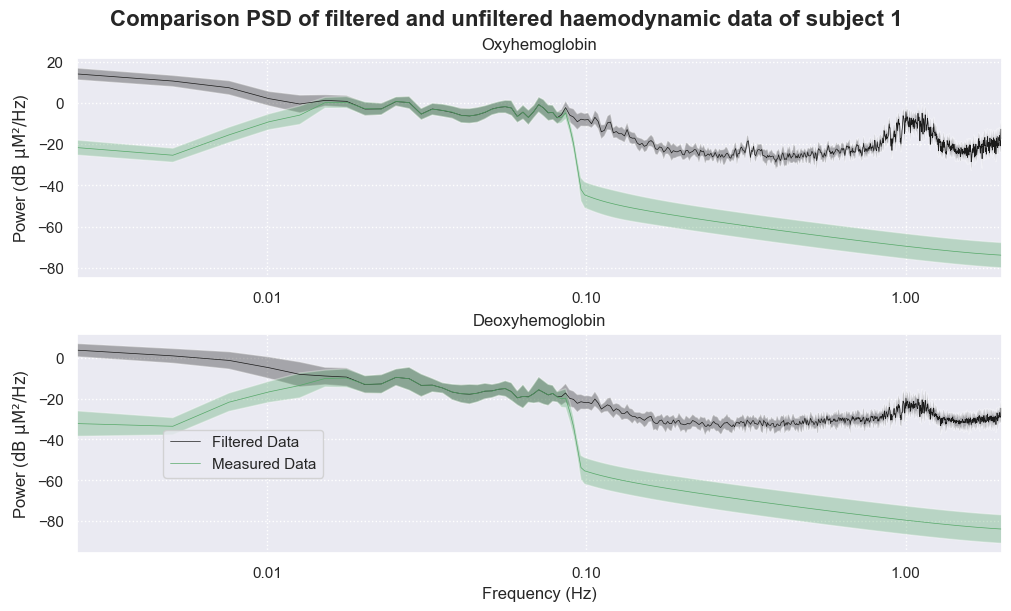

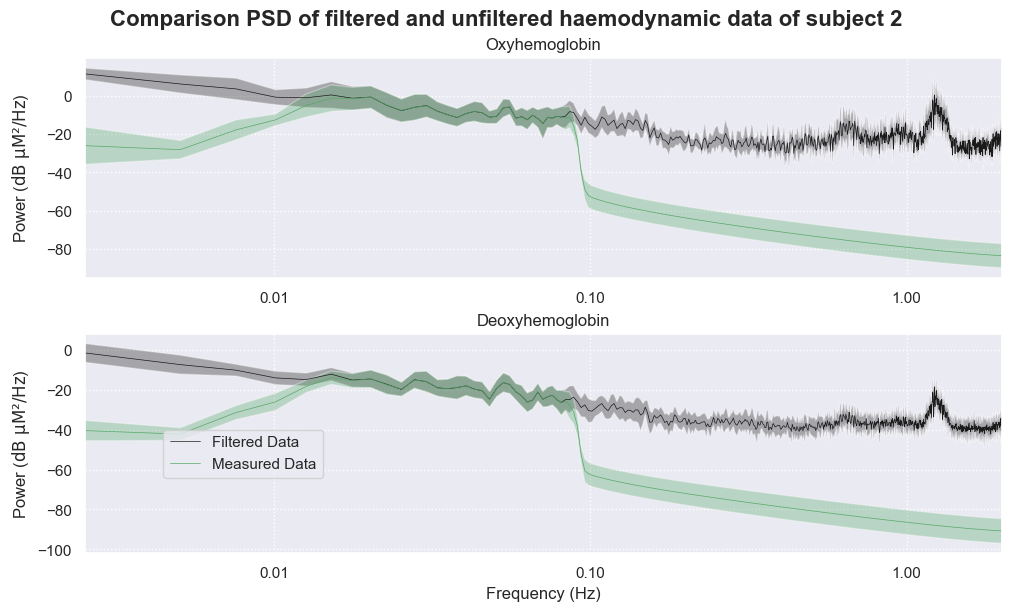

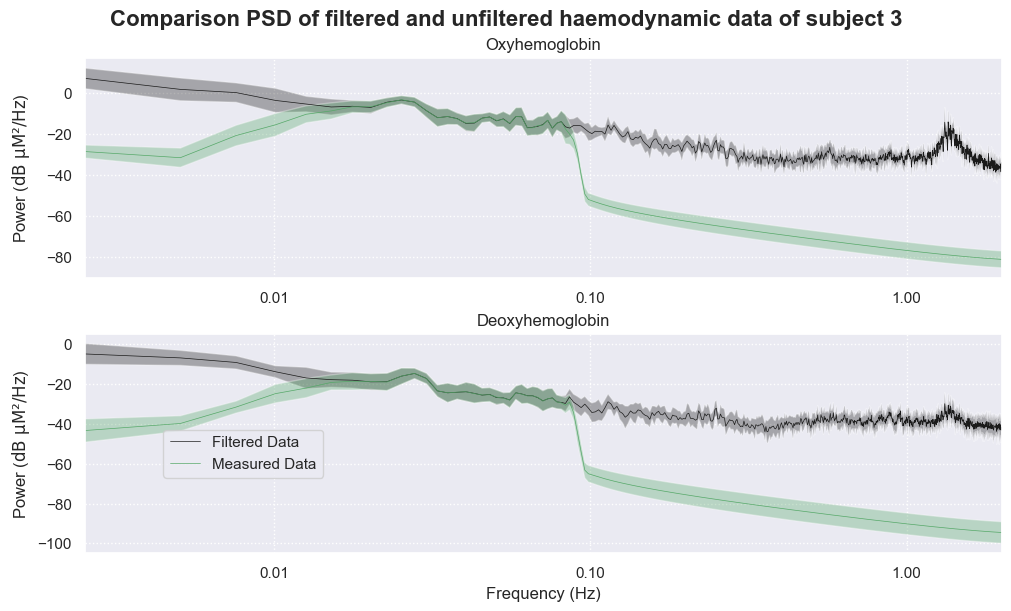

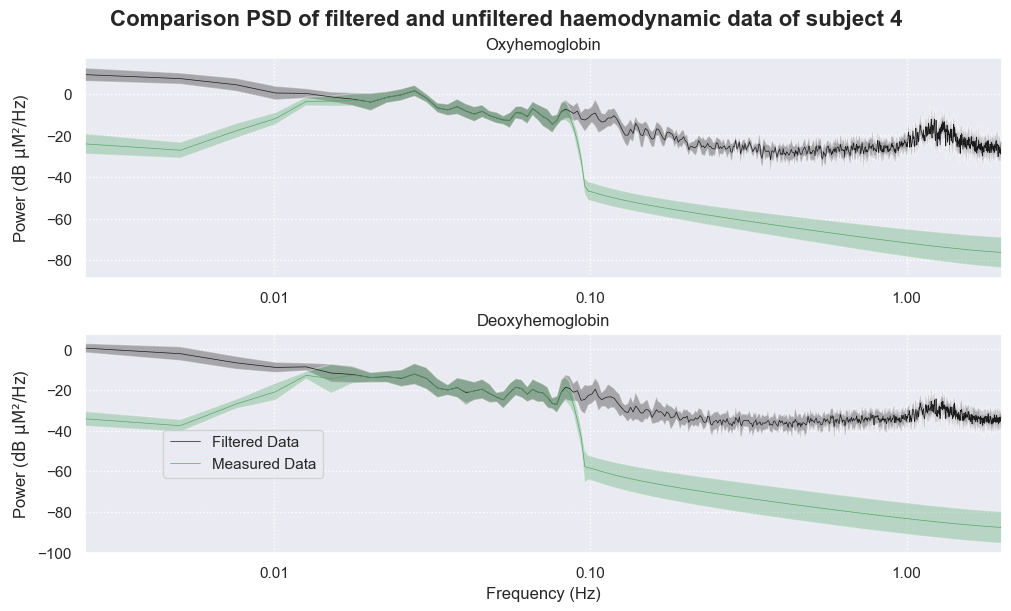

In [121]:
for sub in range(4):
    fig = raw_haemos[sub].plot_psd(average=True, fmax=2, xscale='log', color='k', show=False);
    raw_haemos_filtered[sub].plot_psd(average=True, fmax=2, xscale='log', ax=fig.axes, color='g', show=False);
    leg_lines = [line for line in fig.axes[0].lines if line.get_linestyle() == '-']
    fig.legend(leg_lines, ['Filtered Data', 'Measured Data'], loc="lower left", bbox_to_anchor=(0.15, 0.2))
    fig.suptitle('Comparison PSD of filtered and unfiltered haemodynamic data of subject ' + str(sub + 1), fontsize=16, fontweight='bold')
    if export:
        fig.savefig('PSD/PSD_comparison_after_BPF_subject_' + str(sub+1) + '.png')

In [112]:
def plot_compare_PSD_NR(raw_input, stim_names, stim_duration, export = False, filename = None):
    raw_haemo_filtered = raw_input.copy()

    # Filtered data
    psd_haemo_filtered_hbo = raw_haemo_filtered.copy().pick(picks='hbo').compute_psd()
    psd_haemo_filtered_hbr = raw_haemo_filtered.copy().pick(picks='hbr').compute_psd()
    
    psd_haemo_data_hbo, psd_haemo_freqs_hbo = psd_haemo_filtered_hbo.get_data(return_freqs = True)
    psd_haemo_data_hbr, psd_haemo_freqs_hbr = psd_haemo_filtered_hbr.get_data(return_freqs = True)
    
    psd_haemo_data_hbo = np.mean(psd_haemo_data_hbo, axis = 0)
    psd_haemo_data_hbr = np.mean(psd_haemo_data_hbr, axis = 0)

    # Hrf model
    design_matrix = make_first_level_design_matrix(raw_haemo_filtered, drift_order=0, stim_dur=stim_duration)
    hrf_hbo = raw_input.copy().pick(picks=[0])
    hrf_hbr = raw_input.copy().pick(picks=[1])
    for stim_name in stim_names:
        hrf_hbo._data[0] = 1e-6 * design_matrix[stim_name].T # HbO
        hrf_hbr._data[0] = -5e-7 * design_matrix[stim_name].T # HbR: Half amplitude and negative 
    
    psd_hrf_hbo = hrf_hbo.pick(picks='hbo').compute_psd()
    psd_hrf_hbr = hrf_hbr.pick(picks='hbr').compute_psd()
    
    psd_hrf_data_hbo, psd_hrf_freqs_hbo = psd_hrf_hbo.get_data(return_freqs = True)
    psd_hrf_data_hbr, psd_hrf_freqs_hbr = psd_hrf_hbr.get_data(return_freqs = True)

    # Plotting both PSDs on the same graph
    fig, axes = plt.subplots(1, 2, figsize=(13, 5))
    
    axes[0].plot(psd_haemo_freqs_hbo, psd_haemo_data_hbo.T, label='HbO filtered', color='b')
    axes[0].plot(psd_hrf_freqs_hbo, psd_hrf_data_hbo.T, label='HbO HRF', color='r')
    axes[0].set_xscale('log')
    axes[0].set_yscale('log')
    axes[0].set_xlabel('Frequency (Hz)')
    axes[0].set_ylabel('Power Spectral Density HbO')
    axes[0].axvline(f_experiment, np.min(psd_hrf_freqs_hbo), np.max(psd_hrf_freqs_hbo), color = 'k', label = 'f_experiment: ' + str(round(f_experiment,3)) + ' Hz')
    axes[0].legend()
    
    axes[1].plot(psd_haemo_freqs_hbr, psd_haemo_data_hbr.T, label='HbR filtered', color='b')
    axes[1].plot(psd_hrf_freqs_hbr, psd_hrf_data_hbr.T, label='HbR HRF', color='r')
    axes[1].set_xscale('log')
    axes[1].set_yscale('log')
    axes[1].set_xlabel('Frequency (Hz)')
    axes[1].set_ylabel('Power Spectral Density HbR')
    axes[1].axvline(f_experiment, np.min(psd_hrf_freqs_hbo), np.max(psd_hrf_freqs_hbo), color = 'k', label = 'f_experiment: ' + str(round(f_experiment,3)) + ' Hz')
    axes[1].legend() 
    
    fig.suptitle('PSD comparison between filtered data and HRF model: Subject ' + str(sub+1), weight='bold', size='x-large')
    if export:
        fig.savefig('NR/Compare_NR_filtered_PSD_' + filename + '.png')
    plt.plot()


Effective window size : 395.264 (s)
Effective window size : 395.264 (s)
Effective window size : 395.264 (s)
Effective window size : 395.264 (s)
Effective window size : 395.264 (s)
Effective window size : 395.264 (s)
Effective window size : 395.264 (s)
Effective window size : 395.264 (s)
Effective window size : 395.264 (s)
Effective window size : 395.264 (s)
Effective window size : 395.264 (s)
Effective window size : 395.264 (s)


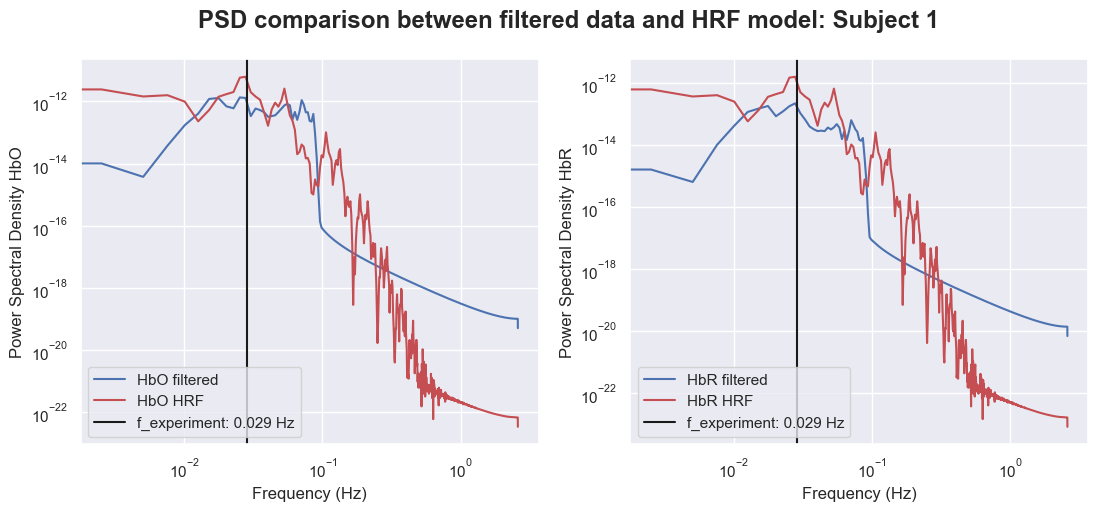

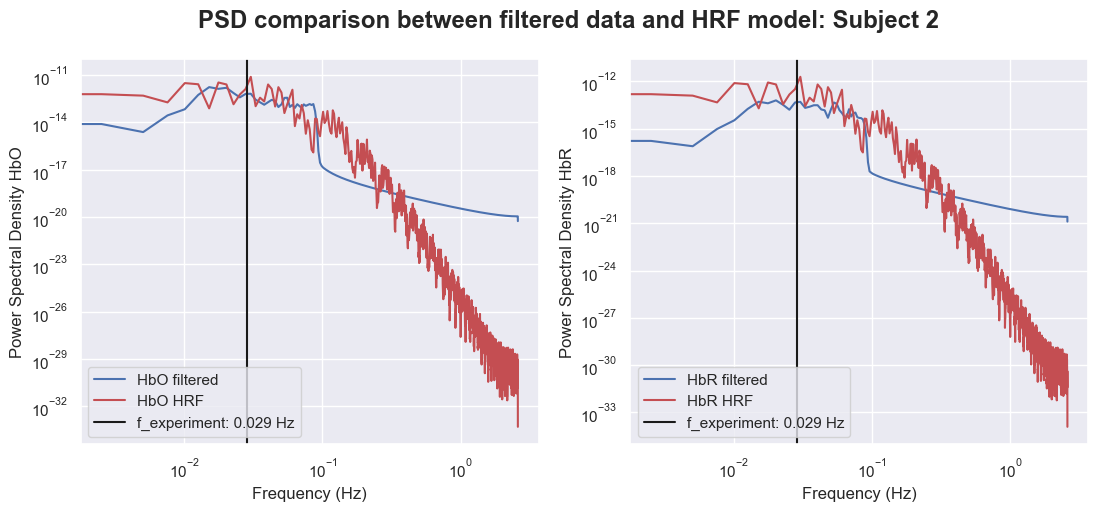

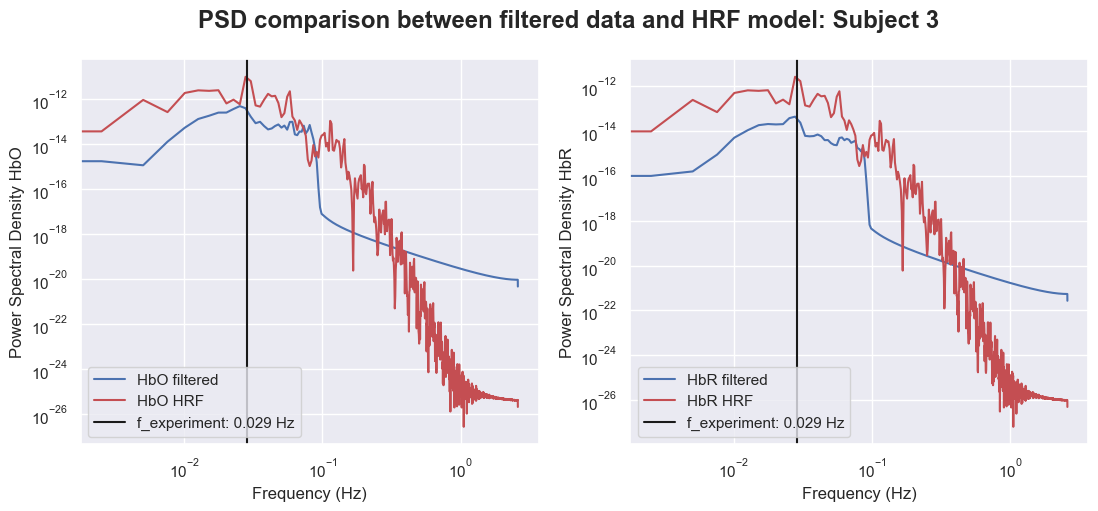

In [123]:
for sub in range(3):
    plot_compare_PSD_NR(raw_haemos_filtered[sub], stim_names, stim_duration, export = export, filename = 'Subject_' + str(sub+1))

Remark: 4th one does not work and I do not find why

---
> *Remark:*
- Transient segment in the beginning of recording is not a problem as the stimuli for grasping were presented later in the recording than 96.5 seconds for all subjects
- However, still use zero-phase filtering as we are working with offline signals
- High frequency noise and VLFO are removed from the signal
- No clear power peak at the stimulus frequency
---

##### Repeat with Butterworth filter

Example of alternative approach with common used Butterworth filter on first subject.

Setting up band-pass filter from 0.01 - 0.09 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.01, 0.09 Hz: -6.02, -6.02 dB



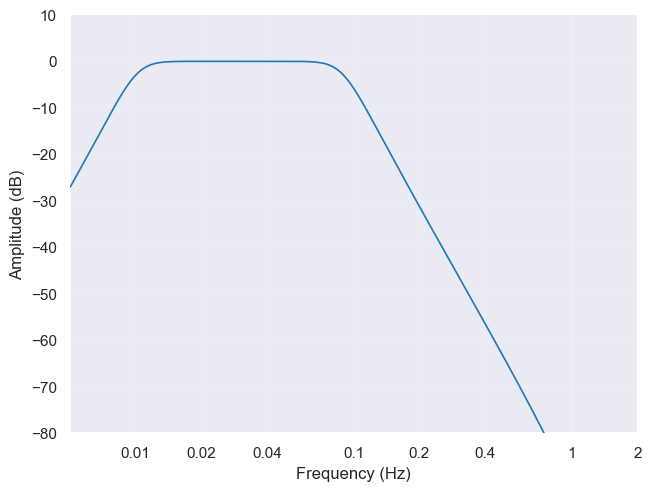

In [114]:
# Set filter charaecteristics
l_freq, h_freq, h_trans_bandwidth, l_trans_bandwidth = 0.01, 0.09, 0.001, 0.005
method2 = 'iir'
filter_params2 = mne.filter.create_filter(raw_haemos[0].get_data(), raw_haemos[0].info['sfreq'], l_freq, h_freq, h_trans_bandwidth = h_trans_bandwidth, l_trans_bandwidth = l_trans_bandwidth, filter_length='auto', method=method2, iir_params=None, phase='zero', fir_window='hamming', fir_design='firwin', verbose=None)
fig = mne.viz.plot_filter(filter_params2, raw_haemos[0].info['sfreq'], flim=(0.005, 2), fscale='log', gain=False, plot='magnitude')

Effective window size : 395.264 (s)
Plotting power spectral density (dB=True).


C:\Users\fabia\AppData\Local\Temp\ipykernel_12440\2756721089.py:2: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  fig = raw_haemos[0].copy().pick(picks='hbo').compute_psd().plot(average=True, exclude="bads", xscale='log', color = 'b')
C:\Users\fabia\AppData\Roaming\Python\Python311\site-packages\mne\viz\utils.py:167: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


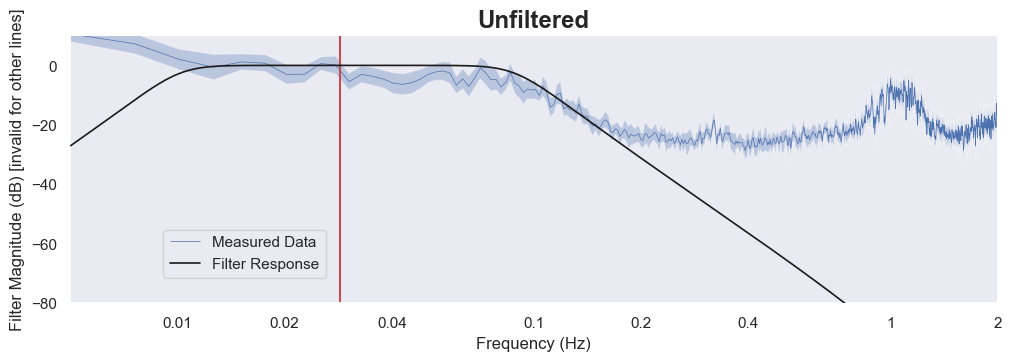

In [115]:
# Combine in one plot
fig = raw_haemos[0].copy().pick(picks='hbo').compute_psd().plot(average=True, exclude="bads", xscale='log', color = 'b')
mne.viz.plot_filter(filter_params2, raw_haemos[0].info['sfreq'], flim=(0.005, 2), fscale='log', gain=False, plot='magnitude', axes=fig.axes, show=False, color = 'k')
plt.vlines(f_experiment, 20, -120, 'r')

leg_lines = [line for line in fig.axes[0].lines if line.get_linestyle() == '-']
fig.legend(leg_lines, ['Measured Data', 'Filter Response'], loc="lower left", bbox_to_anchor=(0.15, 0.2))
fig.axes[0].set_ylabel('Filter Magnitude (dB) [invalid for other lines]')
fig.axes[0].set_title('Unfiltered', weight='bold', size='x-large');

In [116]:
raw_haemo_filtered2 = raw_haemos[0].copy()
# Filter Haemoglobin concentration with zero phase 4th order Butterworth
raw_haemo_filtered2.filter(l_freq, h_freq, h_trans_bandwidth = h_trans_bandwidth, l_trans_bandwidth = l_trans_bandwidth, method = method2)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.09 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.01, 0.09 Hz: -6.02, -6.02 dB



<RawSNIRF | sub-01_task-grasping_nirs.snirf, 48 x 6160 (1188.7 s), ~2.3 MB, data loaded>

Effective window size : 395.264 (s)
Plotting power spectral density (dB=True).


C:\Users\fabia\AppData\Local\Temp\ipykernel_12440\3598171423.py:2: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  fig = raw_haemo_filtered2.copy().pick(picks='hbo').compute_psd().plot(average=True, exclude="bads", xscale='log', color = 'g')
C:\Users\fabia\AppData\Roaming\Python\Python311\site-packages\mne\viz\utils.py:167: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


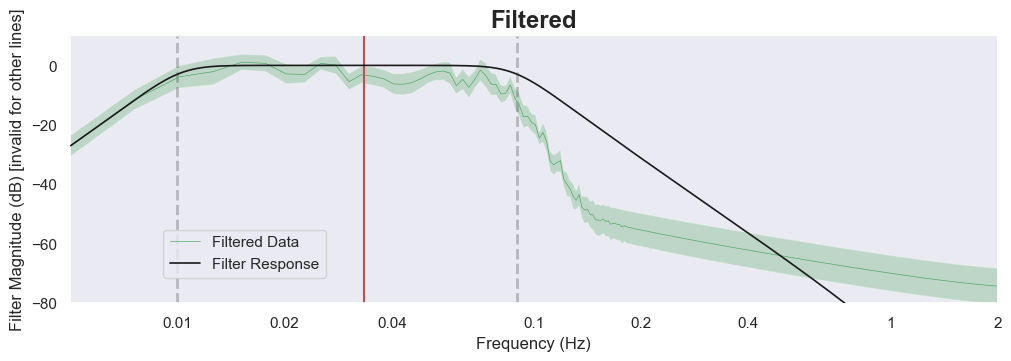

In [117]:
# Combine in one plot
fig = raw_haemo_filtered2.copy().pick(picks='hbo').compute_psd().plot(average=True, exclude="bads", xscale='log', color = 'g')
mne.viz.plot_filter(filter_params2, raw_haemos[0].info['sfreq'], flim=(0.005, 2), fscale='log', gain=False, plot='magnitude', axes=fig.axes, show=False, color = 'k')
plt.vlines(1/30, 20, -120, 'r')

leg_lines = [line for line in fig.axes[0].lines if line.get_linestyle() == '-']
fig.legend(leg_lines, ['Filtered Data', 'Filter Response'], loc="lower left", bbox_to_anchor=(0.15, 0.2))
fig.axes[0].set_ylabel('Filter Magnitude (dB) [invalid for other lines]')
fig.axes[0].set_title('Filtered', weight='bold', size='x-large');

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 395.264 (s)
Plotting power spectral density (dB=True).
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 395.264 (s)
Plotting power spectral density (dB=True).


C:\Users\fabia\AppData\Local\Temp\ipykernel_12440\302139791.py:1: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  fig = raw_haemos[0].plot_psd(average=True, fmax=2, xscale='log', color='k', show=False);
C:\Users\fabia\AppData\Local\Temp\ipykernel_12440\302139791.py:2: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  raw_haemo_filtered2.plot_psd(average=True, fmax=2, xscale='log', ax=fig.axes, color='g', show=False);


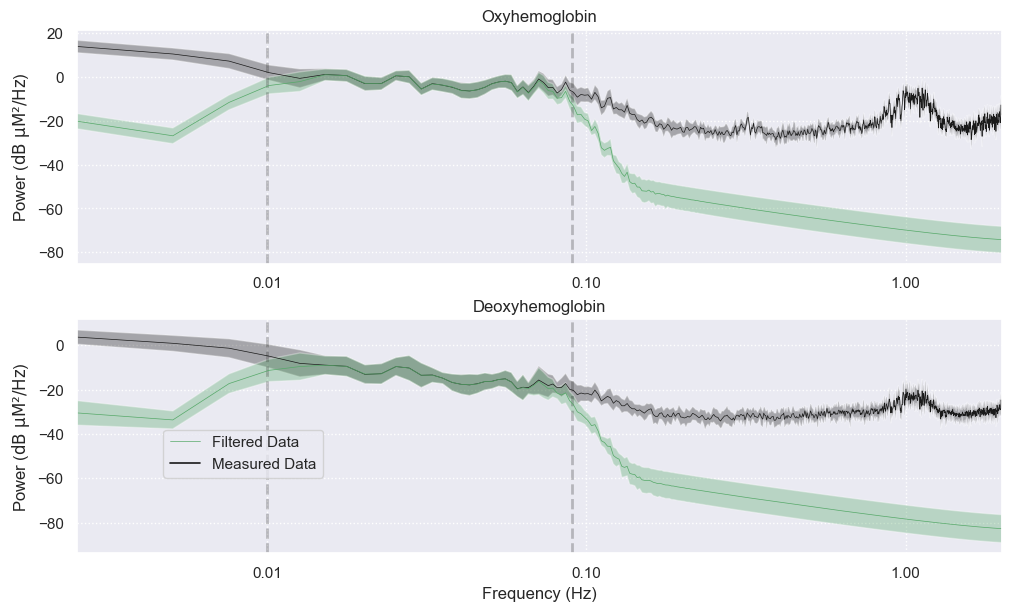

In [118]:
fig = raw_haemos[0].plot_psd(average=True, fmax=2, xscale='log', color='k', show=False);
raw_haemo_filtered2.plot_psd(average=True, fmax=2, xscale='log', ax=fig.axes, color='g', show=False);
fig.legend(leg_lines, ['Filtered Data', 'Measured Data'], loc="lower left", bbox_to_anchor=(0.15, 0.2))

Effective window size : 395.264 (s)
Effective window size : 395.264 (s)
Effective window size : 395.264 (s)
Effective window size : 395.264 (s)


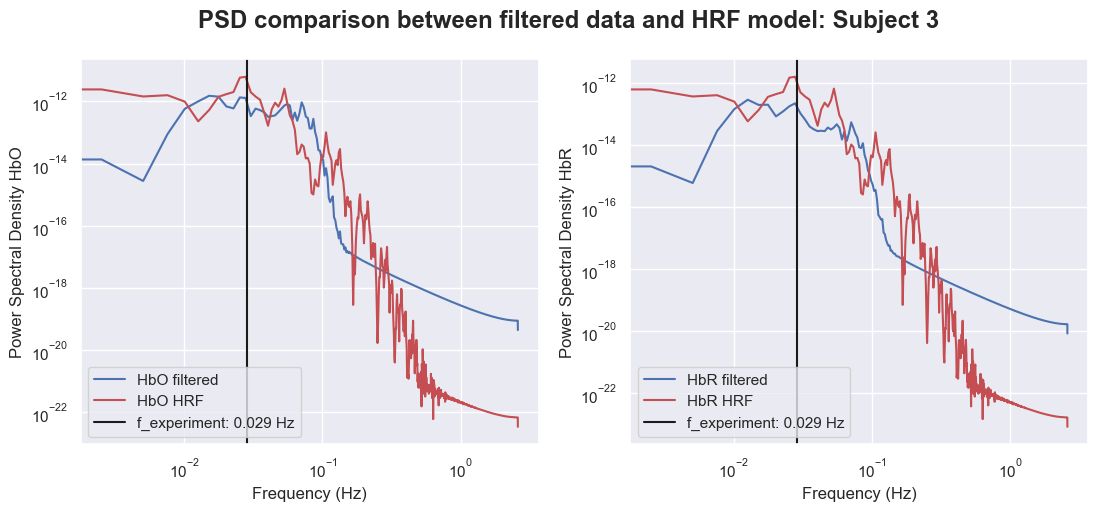

In [119]:
plot_compare_PSD_NR(raw_haemo_filtered2, stim_names, stim_duration, export = export, filename = 'Subject_1_Butter_filter')

In [78]:
compare_original_filtered(raw_haemo_filtered2, raw_haemos[0])

#### FOOOF - example code  <a class="anchor" id="sub_section_1_7_2"></a>

FOOOF stands for *fitting oscillations and one over f* and was developed originally for  electrophysiological data, such as EEG, by Donoghue et al. (2020). According to the developers, FOOOF is a fast, efficient, and physiologically-informed tool to parameterize neural power spectra.

In fNIRS research, the FOOOF algorithm can be utilized to quantify Mayer wave parameters. Mayer waves are challenging to remove from the haemodynamic signals of brain activity because their frequencies often coincide with those of sensory tasks and/or the cortical haemodynamic response to those tasks. FOOOF will fit of a periodic and aperiodic component to the power spectrum of the fNIRS data and the goal is to  fit a periodic component to the peak at around 0.1 Hz that reflects the Mayer wave activity. Once this component is identified, it can then be filtered out.

##### Process data with FOOOF

In [ ]:
raw_haemo = raw_haemos[0].copy()

In [ ]:
# Prepare data for FOOOF (DOI: 10.1038/s41593-020-00744-x)
# Estimate the power spectral density of the data and pass this to the FOOOF algorithm
psd = raw_haemo.compute_psd(fmin=0.001, fmax=1.0, tmin=0, tmax=None, n_overlap=300, n_fft=600)

spectra, freqs = psd.get_data(return_freqs=True)
# FOOOF requires the frequency values to be higher than the fNIRS data permits, so we scale the values up by 10 here,
# and then will scale the frequency values down by 10 later.
spectra, freqs = scale_up_spectra(spectra, freqs) 

# Specify the model, note that frequency values here are times 10
fm = FOOOF(peak_width_limits=(0.5, 12.0))
# Set the frequency range to fit the model, again these are times 10
freq_range = [0.001, 7]

fm.fit(freqs, np.mean(spectra, axis=0), freq_range)

# Plot in semi-log space (log10 power values and linear frequencies)
%matplotlib inline
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
fm.plot(plot_peaks='shade', data_kwargs={'color': 'orange'}, ax=axs)
# Correct for x10 scaling above
plt.xticks([0, 1, 2, 3, 4, 5, 6], [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]);

##### Quantify Mayer wave oscillation

In [ ]:
quantify_mayer_fooof(raw_haemo.copy().pick("hbo"), extra_df_fields={"Study": "FTT"})

---
> *Remark:*
- The algorithm manages to find a periodic component with a center frequency around 0.1 Hz which could be assigned to Mayer waves
- A second periodic component is found with $f_c$ equal to approximately 0.25 Hz. Related to breathing? period of 4 seconds
---